# Modelos estudados

u' = r1 * u - a1 * u * v / ( 1 + a2 * u  ) <br>
v' = ef * u - m * v * v

u' = r1 * u - a1 * u * v / ( 1 + a2 * u  ) <br>
v' = ef * u + r2 * v - m * v * v

u' = r1 * u - a1 * u * v / ( 1 + a2 * u  ) <br>
v' = ef * u * v / ( 1 + a2 * u  ) + r2 * v - m * v * v

u' = r1 * u - a1 * u * v / ( 1 + a2 * u + m ) <br>
v' = ( ef * u * v + r3 * v ) / ( 1 + a2 * u + m ) - q * v * v

# Aphid-Ladybeetle study

In [1]:
import copy
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
from tqdm.autonotebook import tqdm
import warnings
import sys

np.seterr('warn')
#warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed=1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<ipython-input-1-725386291a9c>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/2018 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

Retrieving IC data:

In [3]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

aphid_density = aphid_data["Density"].values.flatten()
ladybeetle_density = ladybeetle_data["Density"].values.flatten()
time_list = aphid_data["Time"].values.flatten()

y0 = aphid_ic, ladybeetle_ic

y0

# Regularization

In [4]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

In [5]:
def read_data_file(path, filename):
    raw_data = pd.read_csv(f"{path}/{filename}", usecols=["Time", "Density"])
    return raw_data

In [6]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density,marker='o')
    ax.plot(t_list, mean_density)
    
    plt.xlabel('Time')

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2)

In [7]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)
#t_list = np.linspace(-10, 50, 200)

def regularize_data(time_list, density):
    kernel = RBF(length_scale_bounds=(10,100)) + WhiteKernel(noise_level_bounds=(1e-10, 5e-10))
#    kernel = ConstantKernel(constant_value_bounds = (1.0e-7,1.0e-6)) * RBF(length_scale_bounds = (20,40)) + WhiteKernel(noise_level_bounds = (1.0e-10, 1.0e-9))

#    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-8, n_restarts_optimizer=10, normalize_y=True)
    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=100, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

{'k1': RBF(length_scale=10), 'k2': WhiteKernel(noise_level=5e-10), 'k1__length_scale': 10.000000000000002, 'k1__length_scale_bounds': (10, 100), 'k2__noise_level': 4.999999999999994e-10, 'k2__noise_level_bounds': (1e-10, 5e-10)}
Initial: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Optimum: RBF(length_scale=10) + WhiteKernel(noise_level=5e-10)
Log-Marginal-Likelihood: -525176668.4513282


/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 5e-10. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Aphid population')

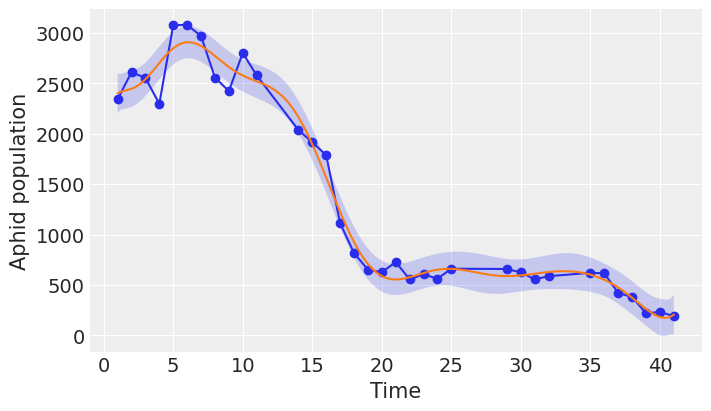

In [8]:
(mean_density, min_density, max_density) = regularize_data(time_list, aphid_density)
plot_data(time_list, aphid_density, mean_density, min_density, max_density)
plt.ylabel('Aphid population')

In [9]:
#aphid_density = aphid_data.Density.values
aphid_density = mean_density

In [10]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)

def regularize_data(time_list, density):
#    kernel = RBF(length_scale_bounds=(20,40)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e-2))
#    kernel = ConstantKernel(constant_value_bounds = (60.0, 70.0))*RBF(length_scale_bounds = (25,45)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))
#    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0))*RBF(length_scale_bounds = (20,45)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))
    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
#    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-2, n_restarts_optimizer=50, normalize_y=True)
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

{'k1': 0.316**2, 'k2': WhiteKernel(noise_level=0.01), 'k1__constant_value': 0.10000000000000002, 'k1__constant_value_bounds': (0.1, 1.0), 'k2__noise_level': 0.010000000000000004, 'k2__noise_level_bounds': (0.001, 0.01)}
Initial: 1**2 + WhiteKernel(noise_level=1)
Optimum: 0.316**2 + WhiteKernel(noise_level=0.01)
Log-Marginal-Likelihood: -1655.871941370817


/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Ladybeetle population')

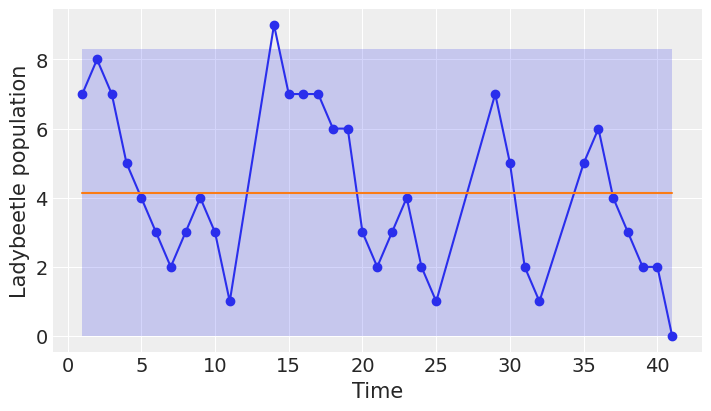

In [11]:
(mean_density, min_density, max_density) = regularize_data(time_list, ladybeetle_density)
plot_data(time_list, ladybeetle_density, mean_density, min_density, max_density)
plt.ylabel('Ladybeetle population')

In [12]:
#ladybeetle_density = ladybeetle_data.Density.values
ladybeetle_density = mean_density

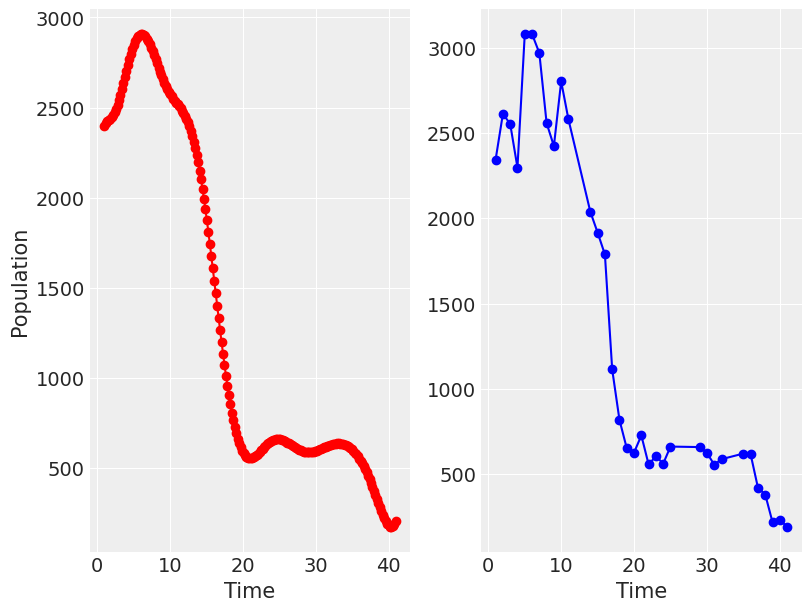

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(t_list, aphid_density, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(time_list, aphid_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

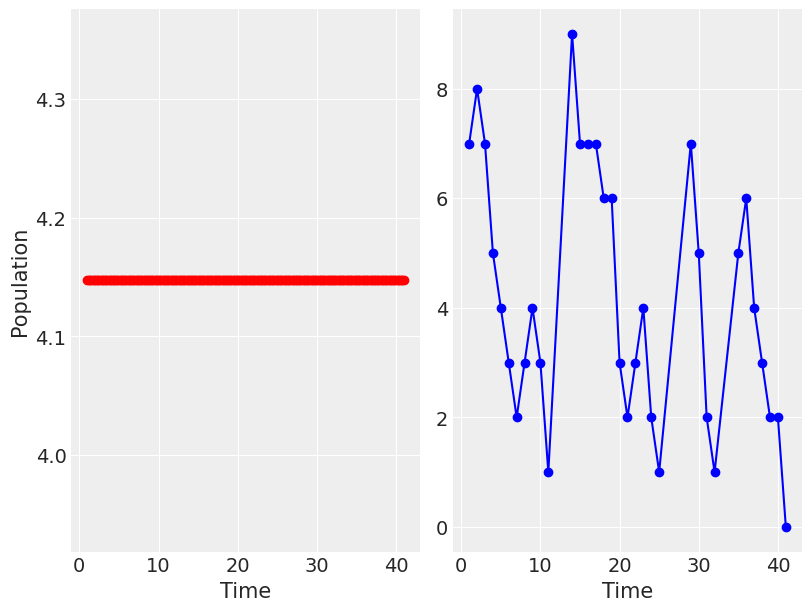

In [14]:
import matplotlib.pyplot as plt

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 6))

ax3.plot(t_list, ladybeetle_density, '-o', c='r')
ax3.set(xlabel='Time', ylabel='Population')
ax4.plot(time_list, ladybeetle_data.Density.values, '-o', c='b')
ax4.set(xlabel='Time')
plt.show()

In [15]:
aphid_ic = aphid_density[0]
ladybeetle_ic = ladybeetle_density[0]

In [16]:
y0 = aphid_ic, ladybeetle_ic

y0

(2400.5117688174696, 4.1470588235293935)

In [17]:
time_list = t_list

# Prey-Predator Lucas B model

In [18]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = aphid_ic, ladybeetle_ic

@jit(nopython=True)
def EPPLB_model(
    t,
    X,
    r1 = 10,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    """
    Prey-Predator Lucas B model (EPPLB) python implementation.
    """
    u, v = X
    u_prime = r1 * u - a1 * u * v / ( 1 + a2 * u  )
    v_prime = ef * u - m * v * v
    return u_prime, v_prime

def EPPLB_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 10,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    solution_ODE = solve_ivp(
        fun=EPPLB_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,ef,m,a1,a2),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

(200,)


<ipython-input-19-799c8d2c2aa4>:36: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


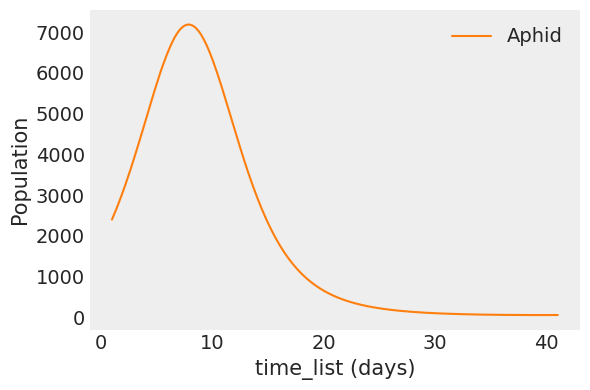

<ipython-input-19-799c8d2c2aa4>:49: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


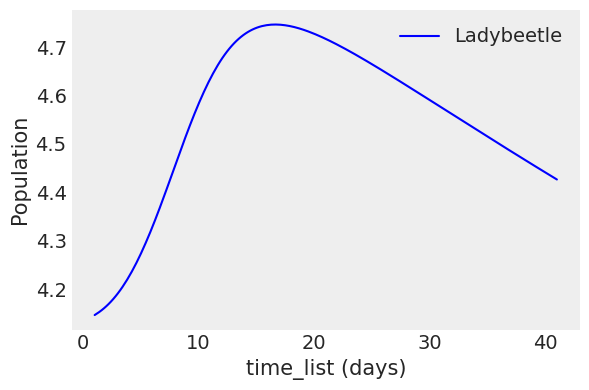

In [19]:
# Testing

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

r1=3.66742272534226
ef=1.1387777257314906e-05
m=0.0007717188879990568
a1=0.8654701509111475
a2=2.3079205719709543e-16

r1=r1*1.05
ef=ef
m=m
a1=a1
a2=a2

solution_ODE = EPPLB_ode_solver(y0,(t0, tf + days_to_forecast),time_list_range,r1=r1,ef=ef,m=m,a1=a1,a2=a2)
t_computed, y_computed = solution_ODE.t, solution_ODE.y
aphid_analytic, ladybeetle_analytic = y_computed

print(aphid_analytic.shape)

plt.figure(figsize=(6, 4))

#plt.axhline(y=vfix, color='blue', linestyle='-')
plt.plot(time_list_range, aphid_analytic, label="Aphid", linestyle="-", markersize=10,color="#ff7f0e")

plt.xlabel("time_list (days)")
plt.ylabel("Population")
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))

#plt.axhline(y=vfix, color='blue', linestyle='-')
plt.plot(time_list_range, ladybeetle_analytic, label="Ladybeetle", linestyle="-", markersize=10,color="blue")

plt.xlabel("time_list (days)")
plt.ylabel("Population")
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.tight_layout()
plt.show()

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [20]:
def EPPLB_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [21]:
from scipy import optimize

seed=seed

r1=3.654463415081314
ef=1.1425674357862622e-05
m=0.0007736897411243538
a1=0.8623401374658384
a2=1.4638265267080344e-16
denom_min = 0.1
denom_max = 1.9
bounds_EPPLB = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( ef * denom_min ), ( ef * denom_max ) ),  # ef
    ( ( m * denom_min ), ( m * denom_max ) ),  # m
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
]

result_EPPLB = optimize.differential_evolution(
    EPPLB_least_squares_error_ode,
    bounds=bounds_EPPLB,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        EPPLB_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_EPPLB)

/home/tungdil/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:492: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 2: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 3: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 4: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 5: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 6: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_evolution step 7: f(x)= 4.68382e+06
parameters = [1.87780669e+00 1.59552582e-05 8.29911309e-04 4.37414606e-01
 1.01523140e-16]

differential_

differential_evolution step 60: f(x)= 3.42186e+06
parameters = [3.66037693e+00 1.14053330e-05 7.72483011e-04 8.63769489e-01
 8.74945773e-17]

differential_evolution step 61: f(x)= 3.42186e+06
parameters = [3.66037693e+00 1.14053330e-05 7.72483011e-04 8.63769489e-01
 8.74945773e-17]

differential_evolution step 62: f(x)= 3.42186e+06
parameters = [3.66037693e+00 1.14053330e-05 7.72483011e-04 8.63769489e-01
 8.74945773e-17]

differential_evolution step 63: f(x)= 3.42186e+06
parameters = [3.66037693e+00 1.14053330e-05 7.72483011e-04 8.63769489e-01
 8.74945773e-17]

differential_evolution step 64: f(x)= 3.42185e+06
parameters = [3.66634878e+00 1.13882244e-05 7.71438529e-04 8.65209558e-01
 1.41267795e-16]

differential_evolution step 65: f(x)= 3.42184e+06
parameters = [3.67098361e+00 1.13701358e-05 7.70031001e-04 8.66327745e-01
 2.17365870e-16]

differential_evolution step 66: f(x)= 3.42184e+06
parameters = [3.67140317e+00 1.13688695e-05 7.69938159e-04 8.66428782e-01
 1.86341680e-16]

differ

* Retrieving the calibrated parameter values:

In [22]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    ef_deterministic,
    m_deterministic,
    a1_deterministic,
    a2_deterministic,
) = result_EPPLB.x

solution_ODE_EPPLB = EPPLB_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_EPPLB.x
)
t_computed_EPPLB, y_computed_EPPLB = solution_ODE_EPPLB.t, solution_ODE_EPPLB.y
u_EPPLB, v_EPPLB = y_computed_EPPLB

parameters_dict = {
    "Model": "EPPLB",
    u"$r1$": r1_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "ef=" + str(ef_deterministic) + "\n" + "m=" + str(m_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=3.676099658465067
ef=1.136291807280769e-05
m=0.0007703183454985423
a1=0.867564210570178
a2=2.0925471112633475e-16


#### Simulation

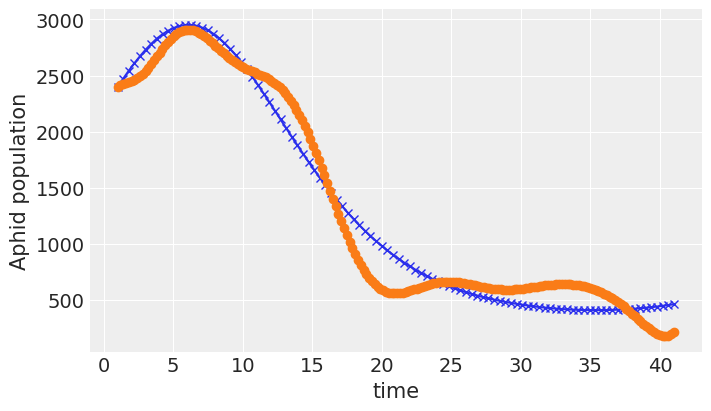

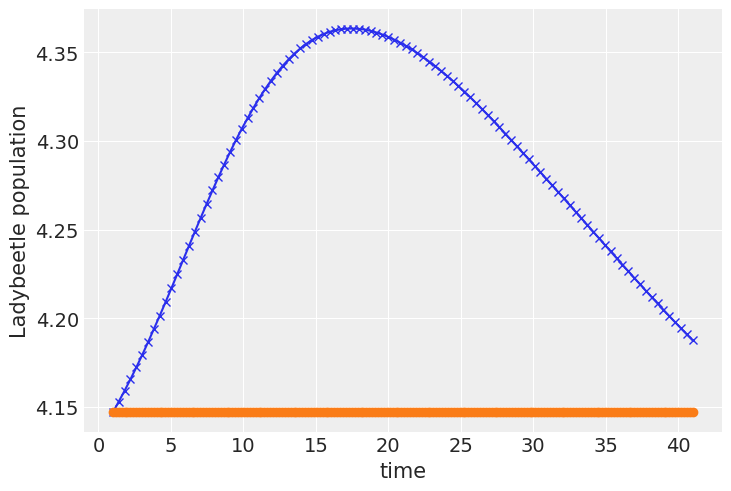

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_EPPLB, u_EPPLB, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_EPPLB, v_EPPLB, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [24]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [25]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = EPPLB_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        EPPLB_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 24/24 [00:00<00:00, 334.30it/s]


In [26]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


,$\mu^*$
$a1$,0.765075
$r1$,0.136372
$ef$,0.0755355
$m$,0.0230175
$a2$,3.01418e-13


<ipython-input-27-c6f1d5040d4b>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


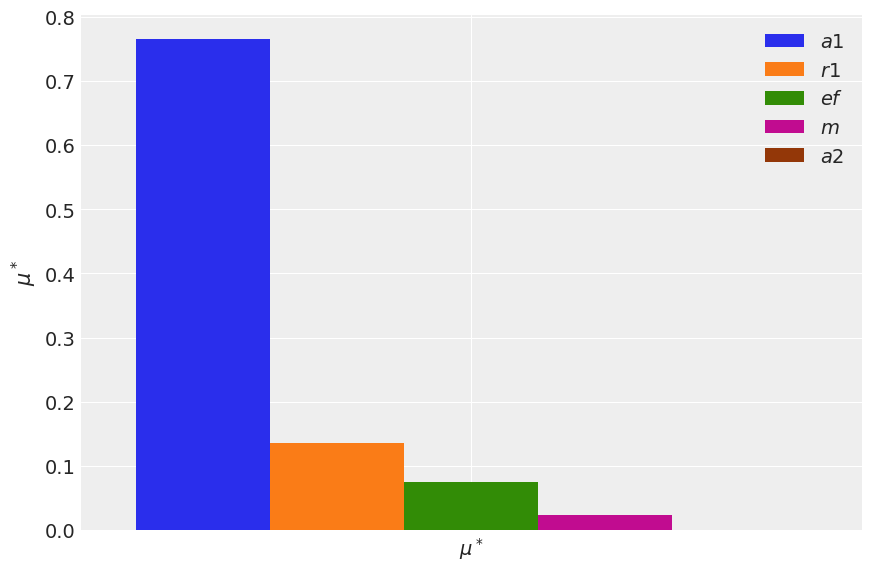

In [27]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_EPPLB.png", dpi=300)
plt.show()

### Prey (pest) population

In [28]:
from SALib.sample.morris import sample as ee_sample
#from SALib.sample.saltelli import sample as ee_sample

mean_values_params = [
    r1,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, num_of_trajectories, seed=seed)

In [29]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EPPLB = EPPLB_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EPPLB.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 24/24 [00:00<00:00, 486.71it/s]


In [30]:
from SALib.analyze.morris import analyze as ee_analyze
#from SALib.analyze.sobol import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 270.08it/s]


,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.469783,0.000821169,0.000418182,0.528978,1.93028e-13
1,1.808081,0.440436,0.00152047,0.00082115,0.557222,2.07318e-13
2,2.212121,0.409092,0.00232982,0.00130747,0.587271,2.20766e-13
3,2.616162,0.377028,0.00336548,0.00189451,0.617712,2.37978e-13
4,3.020202,0.345639,0.00458388,0.00253022,0.647246,2.52539e-13
...,...,...,...,...,...,...
94,39.383838,0.408541,0.0429806,0.0769678,0.471511,3.39692e-13
95,39.787879,0.408658,0.0427842,0.077402,0.471155,2.66737e-13
96,40.191919,0.408823,0.0425882,0.0778187,0.47077,2.99289e-13
97,40.595960,0.409039,0.042389,0.0782173,0.470355,6.0556e-13


In [31]:
df_sigmai

,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.185641,0.0026226,0.000622748,0.811114,2.85563e-13
1,1.808081,0.207362,0.00410066,0.00132141,0.787216,3.29547e-13
2,2.212121,0.198589,0.0064934,0.00207,0.792847,3.70117e-13
3,2.616162,0.187777,0.00965179,0.00294529,0.799626,4.29049e-13
4,3.020202,0.176302,0.0135872,0.00383552,0.806275,4.64931e-13
...,...,...,...,...,...,...
94,39.383838,0.285338,0.0790256,0.136443,0.499193,4.21633e-13
95,39.787879,0.285136,0.0783653,0.136985,0.499513,3.67154e-13
96,40.191919,0.284984,0.0777016,0.137448,0.499867,6.15259e-13
97,40.595960,0.284876,0.0770291,0.13783,0.500265,1.41106e-12


<ipython-input-32-86b68a5358ec>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


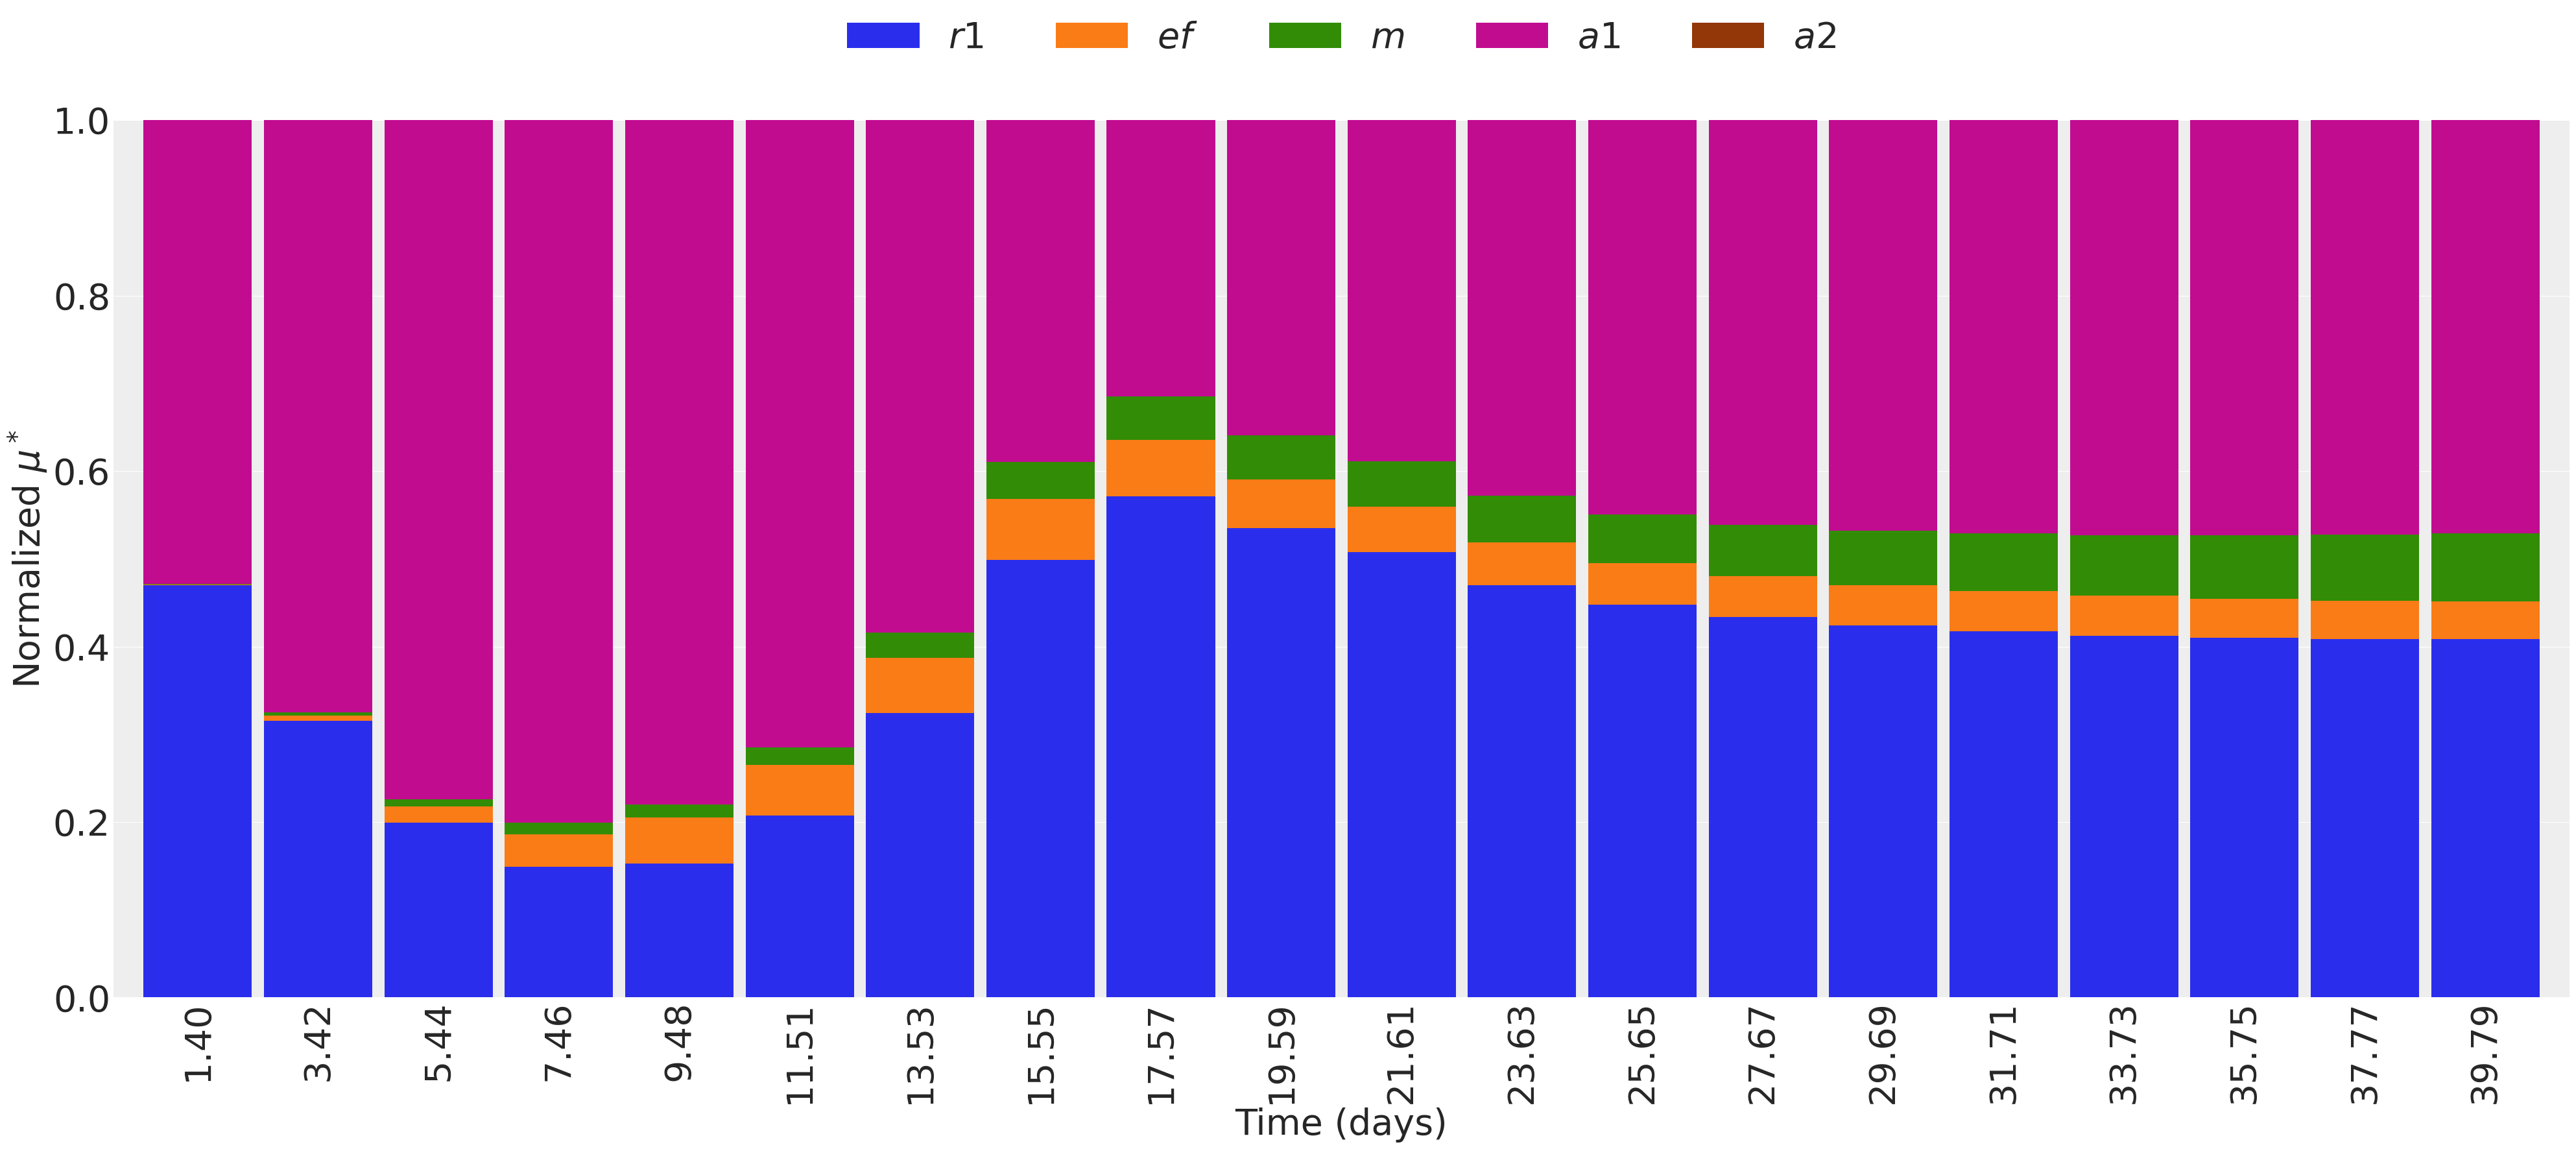

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_EPPLB.png", dpi=300)
plt.show()

<ipython-input-33-b0b472aac4d4>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


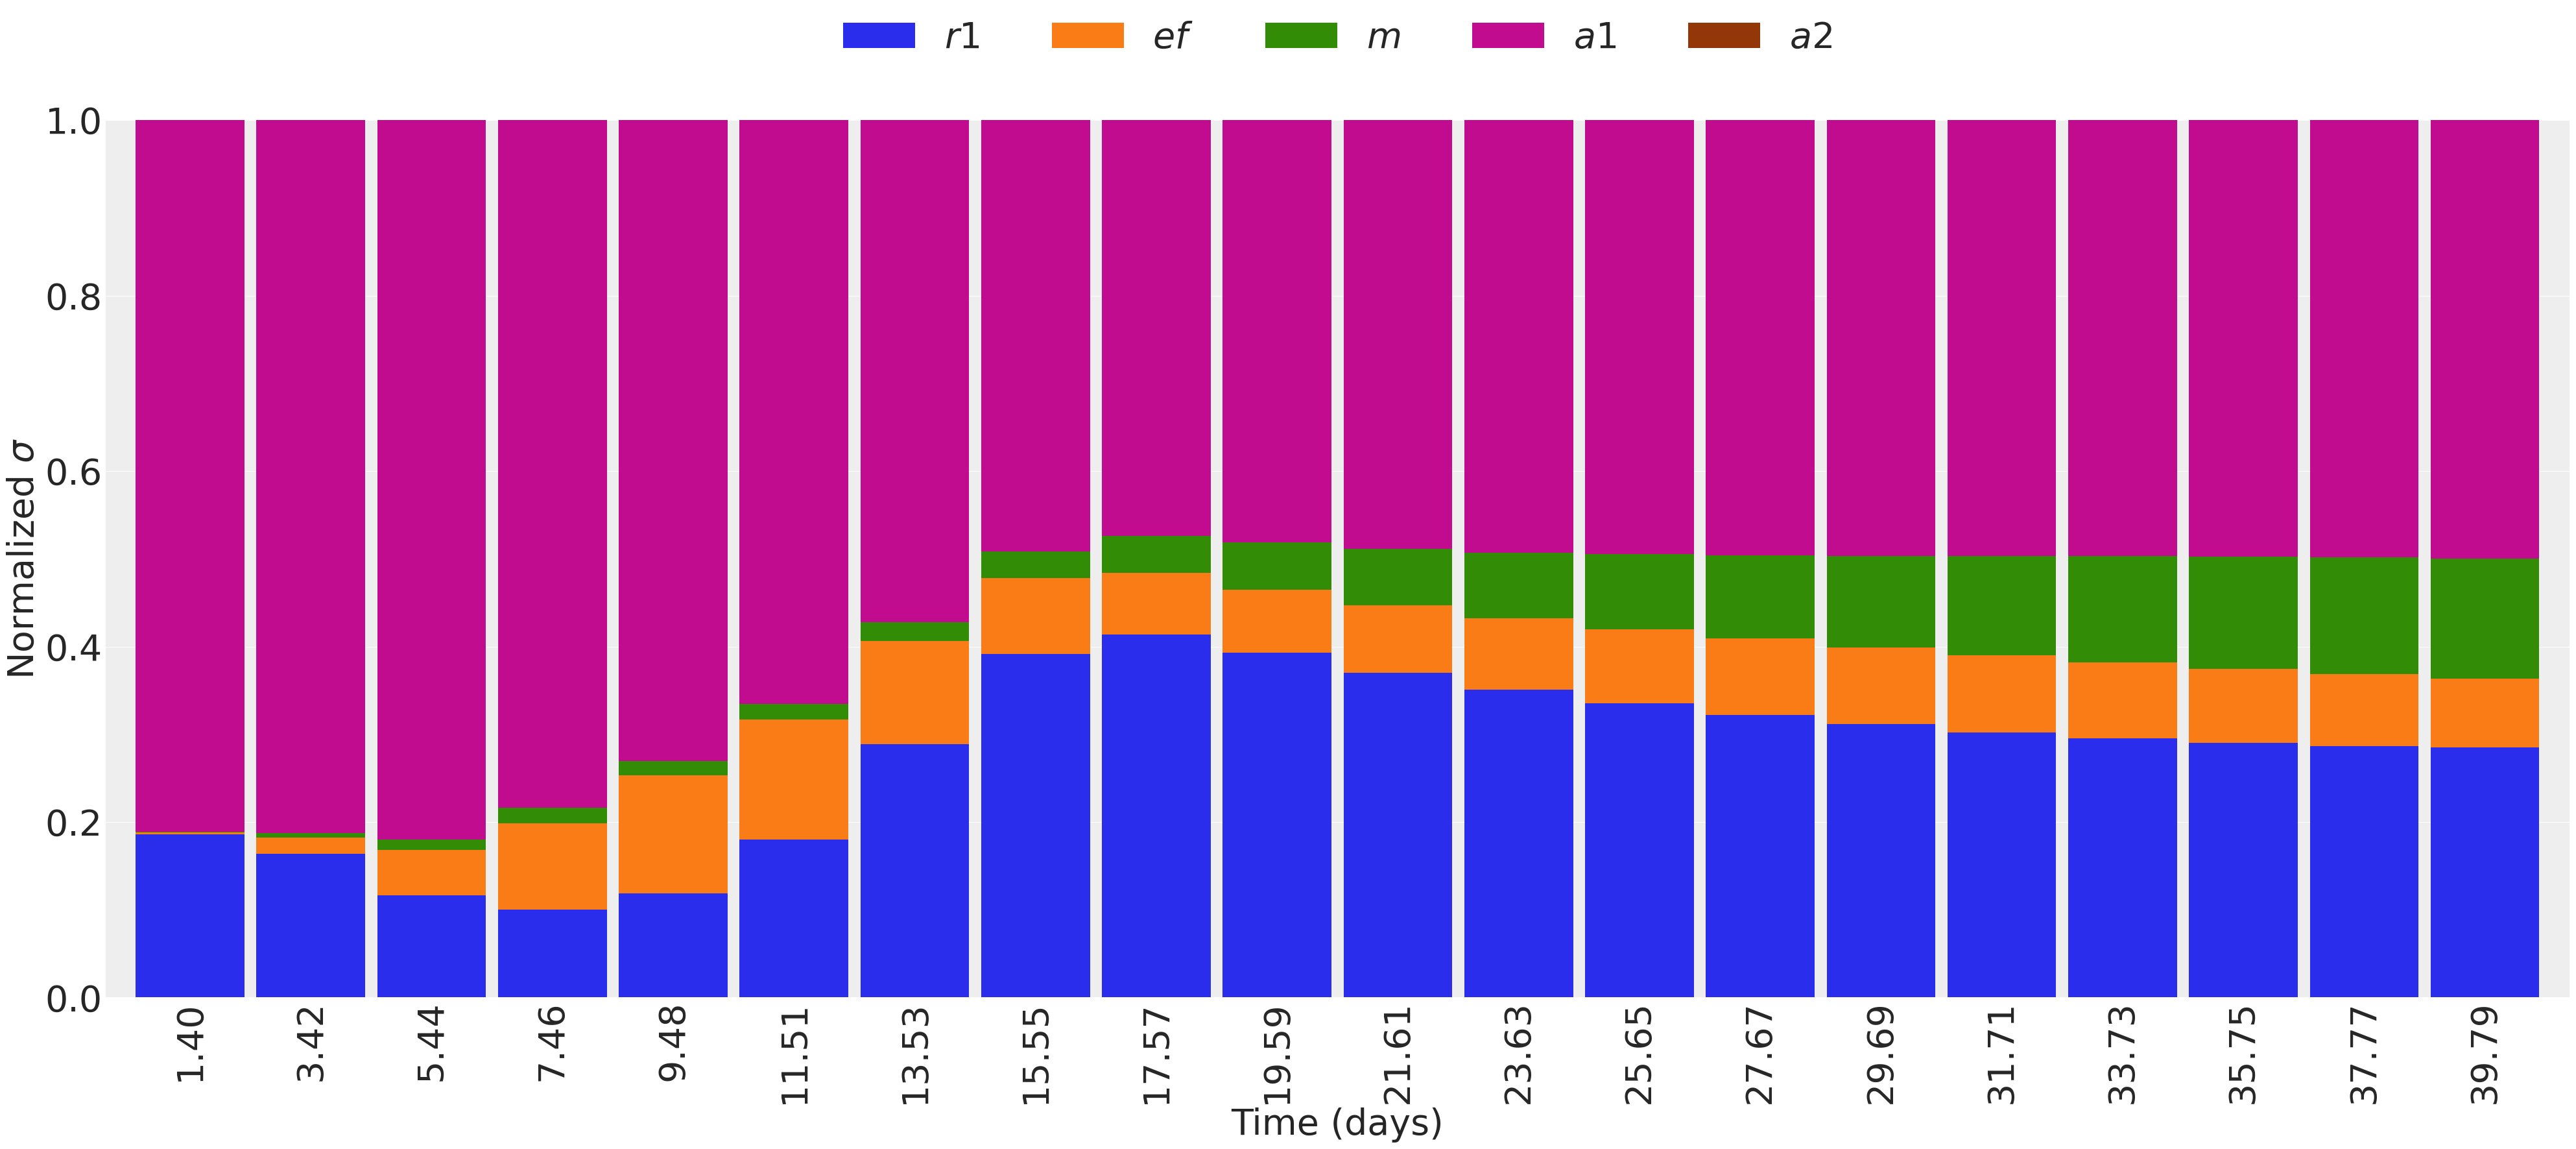

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_EPPLB.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [34]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [35]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_EPPLB,
    u_EPPLB,
    v_EPPLB,
    EPPLB_model,
    mean_values_params
)

pest_time_list_derivative_array

/home/tungdil/.local/lib/python3.8/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'X' of function 'EPPLB_model'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-18-6d7a7c3b0f5f>", line 10:
@jit(nopython=True)
def EPPLB_model(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([ 1.87931599e+02,  1.80499567e+02,  1.72232731e+02,  1.62307135e+02,
        1.50743879e+02,  1.37587217e+02,  1.22942757e+02,  1.06756965e+02,
        8.96032295e+01,  7.13372511e+01,  5.21563243e+01,  3.23370711e+01,
        1.21443041e+01, -8.14838206e+00, -2.82563729e+01, -4.79356526e+01,
       -6.69550662e+01, -8.50830260e+01, -1.02100804e+02, -1.17837668e+02,
       -1.32174474e+02, -1.44991434e+02, -1.56193302e+02, -1.65755051e+02,
       -1.73657980e+02, -1.79939334e+02, -1.84655454e+02, -1.87869020e+02,
       -1.89684240e+02, -1.90207212e+02, -1.89549179e+02, -1.87856220e+02,
       -1.85209073e+02, -1.81741788e+02, -1.77584901e+02, -1.72868525e+02,
       -1.67693264e+02, -1.62144879e+02, -1.56318782e+02, -1.50305028e+02,
       -1.44171236e+02, -1.37975069e+02, -1.31776301e+02, -1.25711508e+02,
       -1.19598207e+02, -1.13626244e+02, -1.07813091e+02, -1.02173835e+02,
       -9.67168699e+01, -9.14499171e+01, -8.63809032e+01, -8.15138934e+01,
       -7.68507197e+01, -

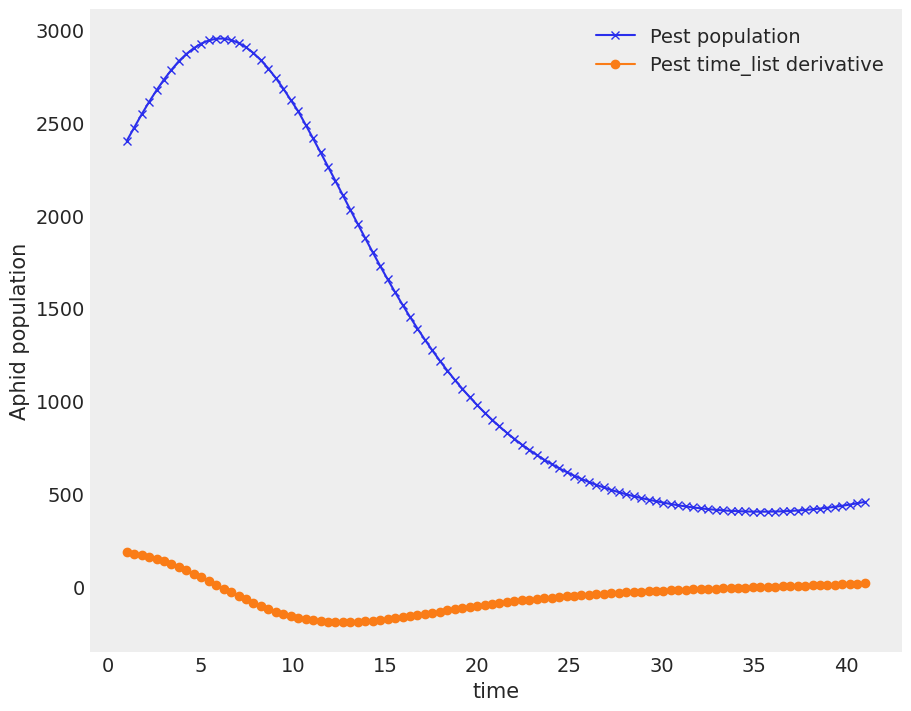

In [36]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_EPPLB, u_EPPLB, '-x', label='Pest population')
plt.plot(t_computed_EPPLB, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_EPPLB.png", dpi=300)
plt.show()

In [37]:
mean_values_params = [
    r1,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [38]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_EPPLB = EPPLB_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_EPPLB.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        EPPLB_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

100%|██████████| 24/24 [00:00<00:00, 400.16it/s]


In [39]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 227.69it/s]


,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.44299,0.00143962,0.000747467,0.554823,2.0699e-13
1,1.808081,0.375865,0.00312095,0.00173184,0.619283,2.35678e-13
2,2.212121,0.308231,0.00519979,0.00295476,0.683614,2.66801e-13
3,2.616162,0.244669,0.00785192,0.00442272,0.743057,3.00619e-13
4,3.020202,0.188203,0.011421,0.00607925,0.794297,3.34212e-13
...,...,...,...,...,...,...
94,39.383838,0.411714,0.0361507,0.0935175,0.458618,4.4029e-13
95,39.787879,0.413545,0.0360914,0.0927614,0.457602,4.85604e-13
96,40.191919,0.415297,0.0360402,0.0920777,0.456585,6.18882e-13
97,40.595960,0.416986,0.0359969,0.0914593,0.455557,8.41315e-13


In [40]:
df_sigmai

,time_list,$r1$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.223906,0.00274268,0.000901776,0.77245,3.01717e-13
1,1.808081,0.203126,0.00635322,0.00194266,0.788578,3.7061e-13
2,2.212121,0.182714,0.0108905,0.00323553,0.80316,4.33264e-13
3,2.616162,0.162176,0.0168359,0.00482037,0.816168,5.11534e-13
4,3.020202,0.142746,0.0247551,0.00662853,0.82587,5.88769e-13
...,...,...,...,...,...,...
94,39.383838,0.29941,0.0621815,0.149635,0.488774,8.37763e-13
95,39.787879,0.299174,0.0626538,0.14772,0.490452,9.68876e-13
96,40.191919,0.298807,0.0631686,0.145933,0.492091,1.35006e-12
97,40.595960,0.298289,0.0637323,0.144282,0.493697,1.99961e-12


<ipython-input-41-da9e5ed3ee8f>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


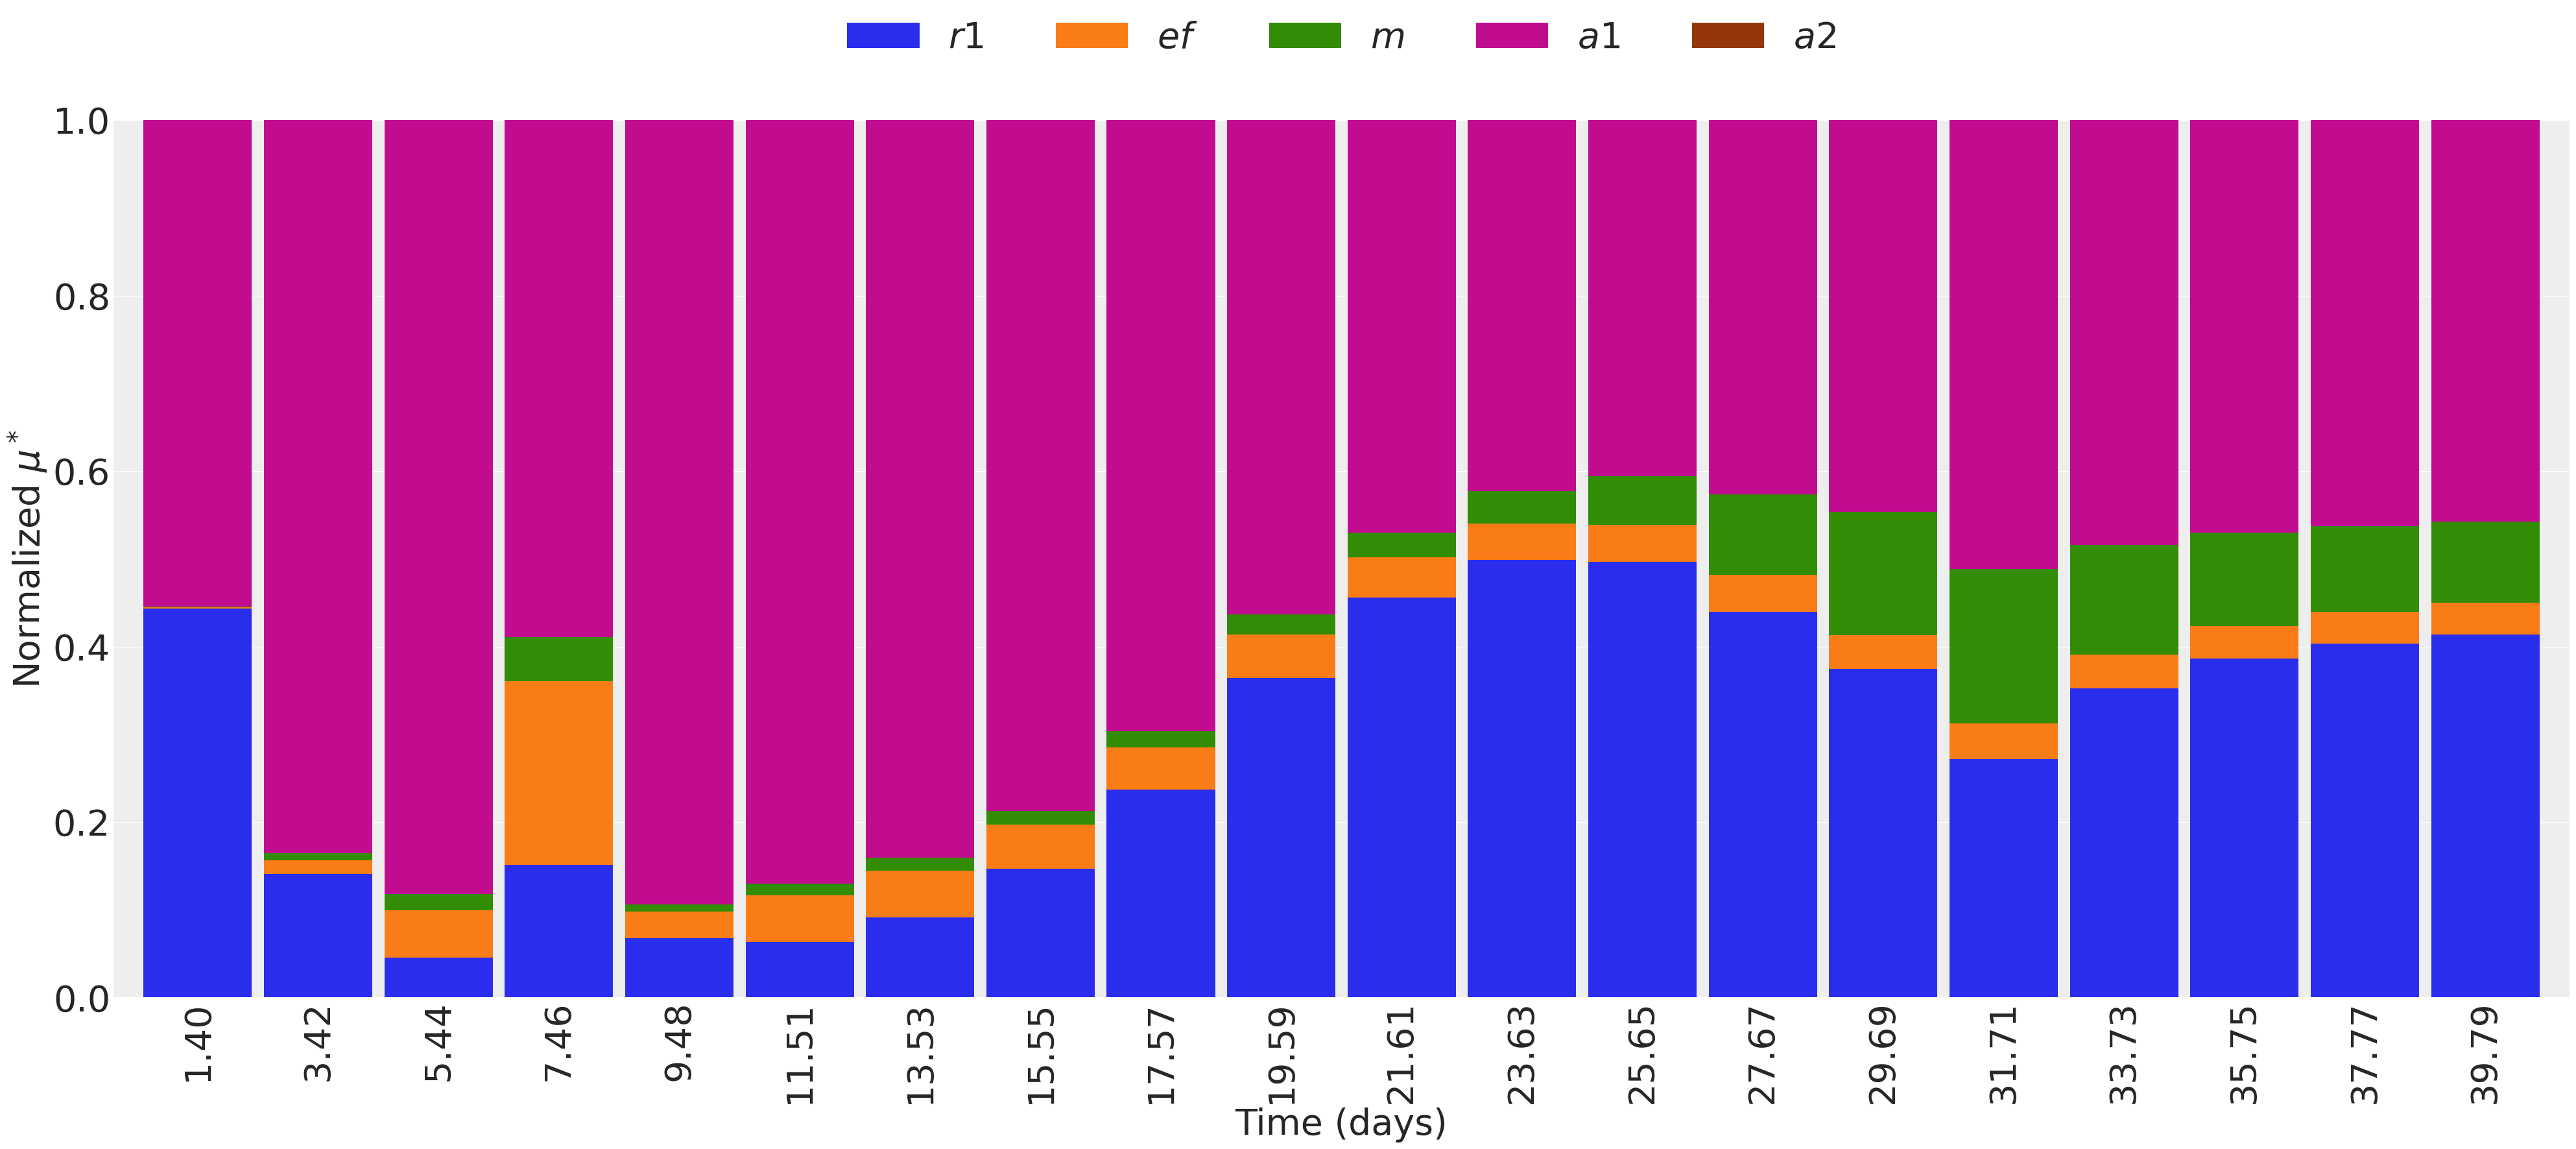

In [41]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_EPPLB.png", dpi=300)
plt.show()

<ipython-input-42-c15d5aefc1d6>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


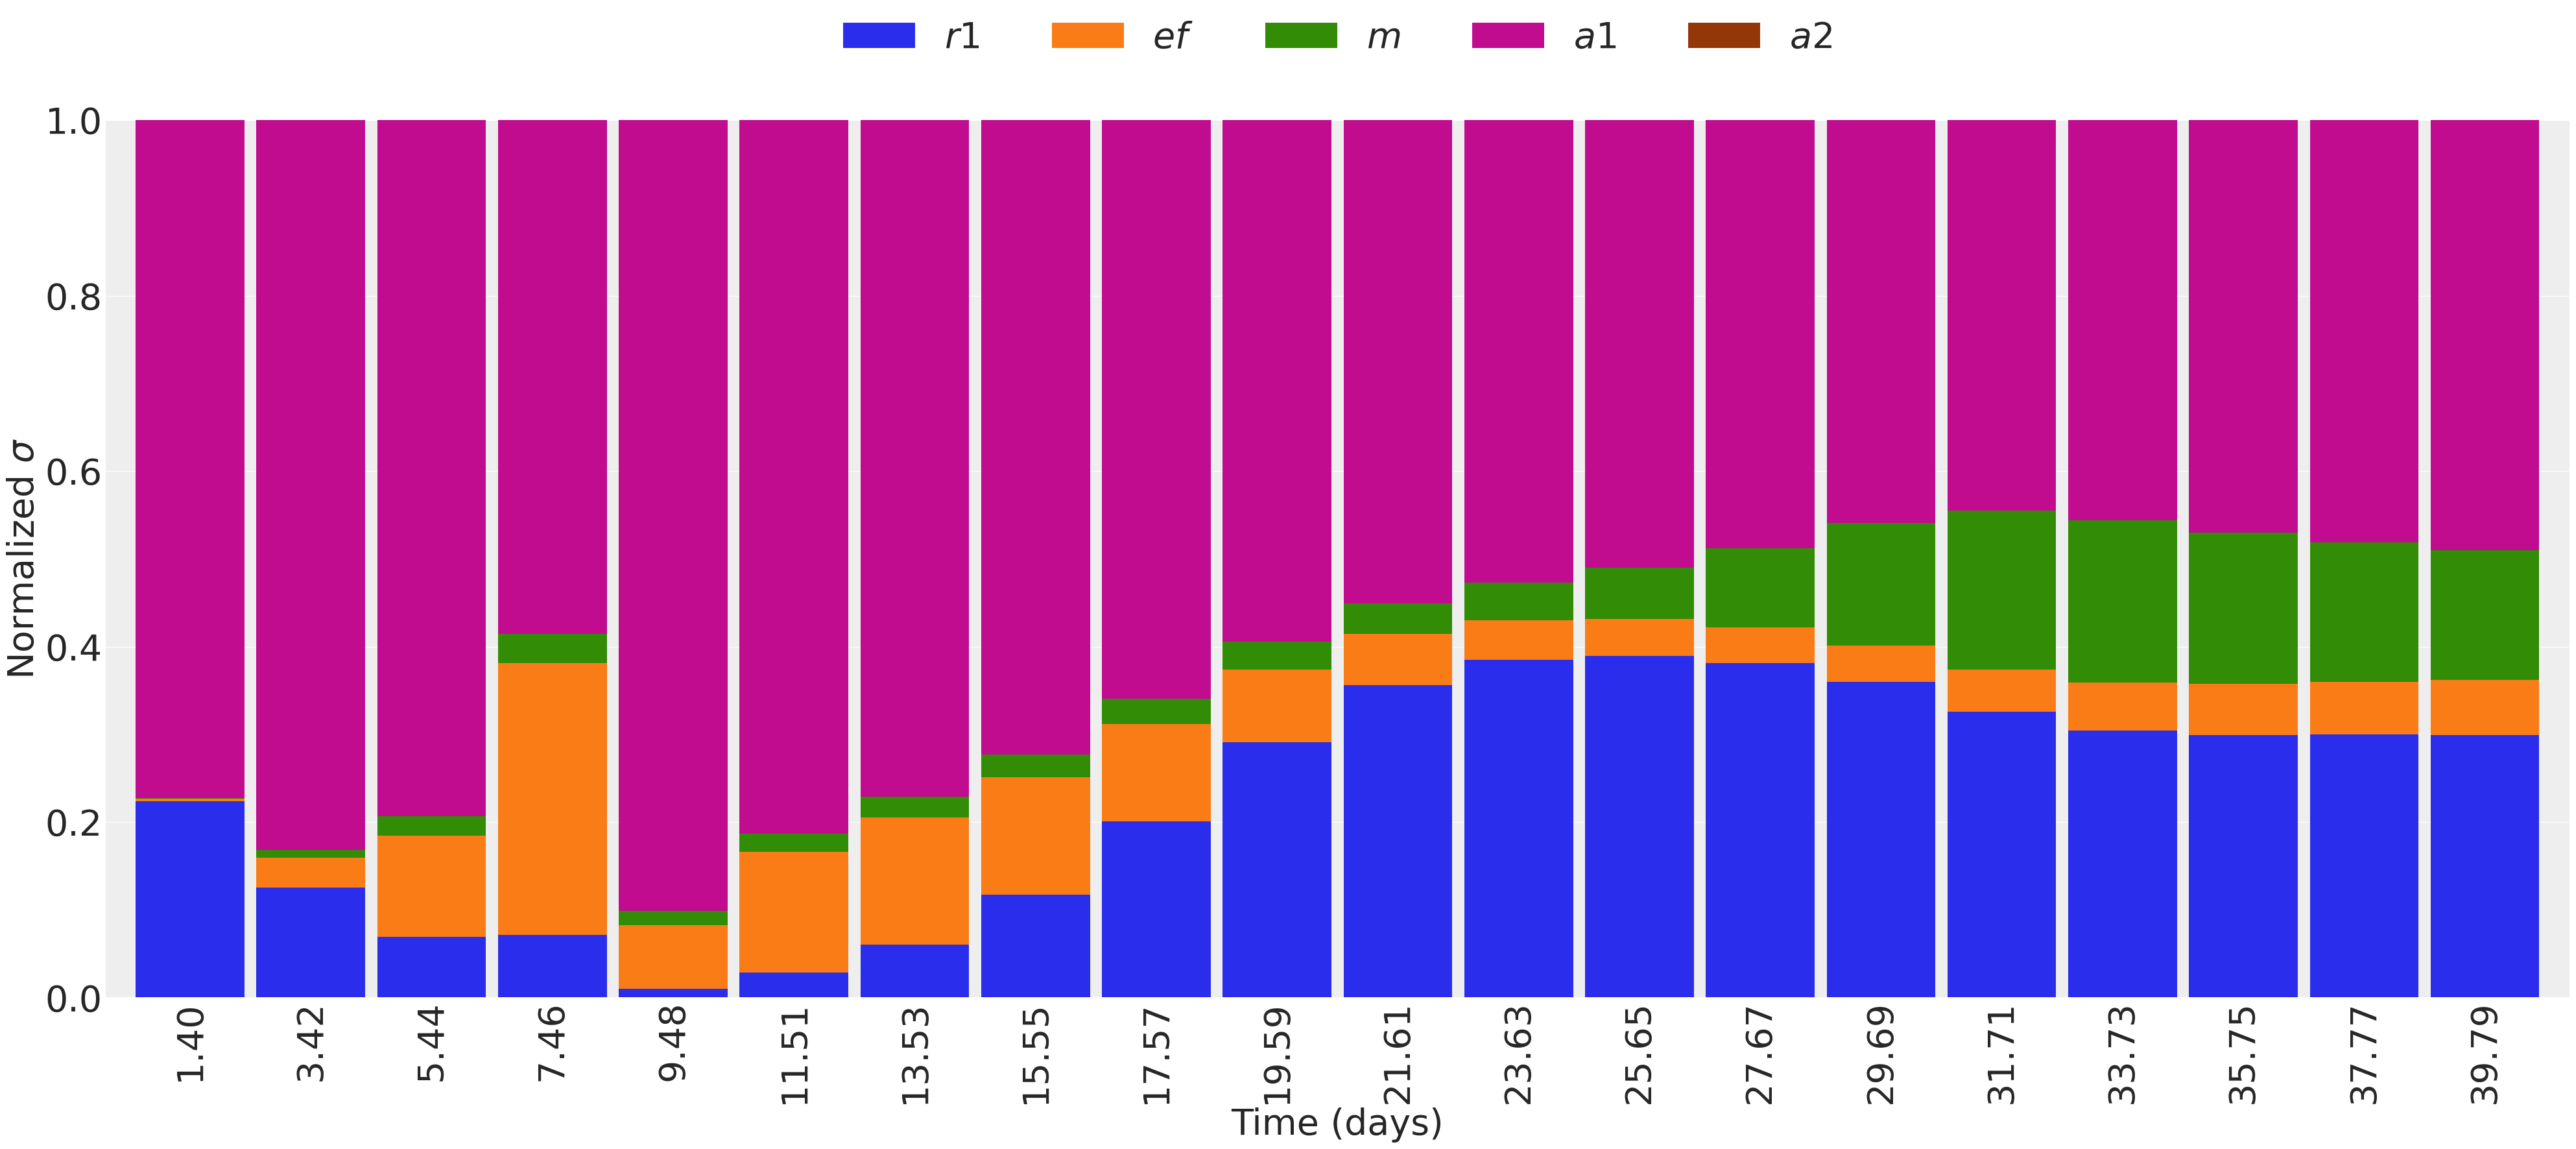

In [42]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_EPPLB.png", dpi=300)
plt.show()

## Bayesian calibration

In [43]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def EPPLB_ode_wrapper(time_list_exp, r1, ef, m, a1, a2, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r1, ef, m, a1, a2]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        EPPLB_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [44]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
#percent_calibration = 0.95
denom_min = 0.95
denom_max = 1.05

with pm.Model() as fine_model_EPPLB:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=4.1,#( r1 * denom_max ),
   )
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=0.98,#( a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=5e3, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EPPLB_model",
        EPPLB_ode_wrapper(
            time_calibration,
            r1_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=4.1,#( r1 * denom_max ),
   )
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=0.98,#( a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=5e3, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "EPPLB_model",
        EPPLB_ode_wrapper(
            time_calibration,
            r1_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_EPPLB:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_EPPLB = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, a1, r1]


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept

ValueError: Not enough samples to build a trace.

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_EPPLB[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_EPPLB.png")

In [ ]:
az.plot_pair(
    trace_calibration_EPPLB,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_EPPLB.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_EPPLB,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_EPPLB, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_EPPLB.csv")  # save in csv format

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_EPPLB["EPPLB_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_EPPLB["EPPLB_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_EPPLB["EPPLB_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_EPPLB.png", dpi=300)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

plt.tight_layout()
plt.savefig("img/calibration_EPPLB.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_EPPLB.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_EPPLB.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Generalist predator

# Predator with Logistic term

# Predator with Logistic term

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = aphid_ic, ladybeetle_ic

@jit(nopython=True)
def GPPLB_model(
    t,
    X,
    r1 = 10,
    r2 = 1,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    """
    Prey-Predator Lucas B model (GPPLB) python implementation.
    """
    u, v = X
    u_prime = r1 * u - a1 * u * v / ( 1 + a2 * u  )
    v_prime = ef * u + r2 * v - m * v * v
    return u_prime, v_prime

def GPPLB_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 10,
    r2 = 1,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    solution_ODE = solve_ivp(
        fun=GPPLB_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,ef,m,a1,a2),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [ ]:
def GPPLB_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [ ]:
from scipy import optimize

seed=seed

r1=4.604360092521496
r2=3.541456860269297e-26
ef=9.04145170988862e-06
m=0.0006231740775980303
a1=1.0915772918968893
a2=3.069682022184211e-17
denom_min = 0.8
denom_max = 1.2
bounds_GPPLB = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( ef * denom_min ), ( ef * denom_max ) ),  # ef
    ( ( m * denom_min ), ( m * denom_max ) ),  # m
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
]

result_GPPLB = optimize.differential_evolution(
    GPPLB_least_squares_error_ode,
    bounds=bounds_GPPLB,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        GPPLB_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_GPPLB)

* Retrieving the calibrated parameter values:

In [ ]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    ef_deterministic,
    m_deterministic,
    a1_deterministic,
    a2_deterministic,
) = result_GPPLB.x

solution_ODE_GPPLB = GPPLB_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_GPPLB.x
)
t_computed_GPPLB, y_computed_GPPLB = solution_ODE_GPPLB.t, solution_ODE_GPPLB.y
u_GPPLB, v_GPPLB = y_computed_GPPLB

parameters_dict = {
    "Model": "GPPLB",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "ef=" + str(ef_deterministic) + "\n" + "m=" + str(m_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

#### Simulation

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_GPPLB, u_GPPLB, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_GPPLB, v_GPPLB, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [ ]:
from SALib.sample.morris import sample as ee_sample
#from SALib.sample.saltelli import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [ ]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = GPPLB_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        GPPLB_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

In [ ]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_GPPLB.png", dpi=300)
plt.show()

### Prey (pest) population

In [ ]:
from SALib.sample.morris import sample as ee_sample
#from SALib.sample.saltelli import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [ ]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_GPPLB = GPPLB_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_GPPLB.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

In [ ]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_GPPLB.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_GPPLB.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [ ]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [ ]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_GPPLB,
    u_GPPLB,
    v_GPPLB,
    GPPLB_model,
    mean_values_params
)

pest_time_list_derivative_array

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_GPPLB, u_GPPLB, '-x', label='Pest population')
plt.plot(t_computed_GPPLB, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_GPPLB.png", dpi=300)
plt.show()

In [ ]:
mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [ ]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_GPPLB = GPPLB_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_GPPLB.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        GPPLB_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

In [ ]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

In [ ]:
df_sigmai

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_GPPLB.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_GPPLB.png", dpi=300)
plt.show()

## Bayesian calibration

In [ ]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def GPPLB_ode_wrapper(time_list_exp, r1, r2, ef, m, a1, a2, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r1, r2, ef, m, a1, a2]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        GPPLB_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [ ]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
#percent_calibration = 0.95
denom_min = 0.95
denom_max = 1.05

with pm.Model() as fine_model_GPPLB:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=( r1 * denom_max ),
   )
    r2_ = pm.Data("r2", r2)
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=( a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "GPPLB_model",
        GPPLB_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=( r1 * denom_min ),
        upper=( r1 * denom_max ),
   )
    r2_ = pm.Data("r2", r2)
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=( a1 * denom_min ),
        upper=( a1 * denom_max ),
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "GPPLB_model",
        GPPLB_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_GPPLB:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_GPPLB = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")

plt.hist(trace_calibration_GPPLB['r1'], bins=35)
plt.show()

In [ ]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
]

In [ ]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_GPPLB[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_GPPLB.png")

In [ ]:
az.plot_pair(
    trace_calibration_GPPLB,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_GPPLB.png")

In [ ]:
df_stats_summary = az.summary(
    data=trace_calibration_GPPLB,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

Auxiliary functions to compute the Most Probable Value (MPV):

In [ ]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [ ]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_GPPLB, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_GPPLB.csv")  # save in csv format

df_stats_summary

In [ ]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_GPPLB["GPPLB_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_GPPLB["GPPLB_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_GPPLB["GPPLB_model"], 50, axis=0)

In [ ]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_GPPLB.png", dpi=300)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

plt.tight_layout()
plt.savefig("img/calibration_GPPLB.png", dpi=300)
plt.show()

In [ ]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_GPPLB.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_GPPLB.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

In [ ]:
df_realizations

# Predator with Logistic term without attraction

In [45]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = aphid_ic, ladybeetle_ic

@jit(nopython=True)
def RMLM_model(
    t,
    X,
    r1 = 10,
    r2 = 1,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    """
    Prey-Predator Lucas B model (RMLM) python implementation.
    """
    u, v = X
    u_prime = r1 * u - a1 * u * v / ( 1 + a2 * u  )
    v_prime = ef * u * v / ( 1 + a2 * u  ) + r2 * v - m * v * v
    return u_prime, v_prime

def RMLM_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 10,
    r2 = 1,
    ef = 0.15,
    m = 1.5,
    a1 = 1,
    a2 = 1,
):
    solution_ODE = solve_ivp(
        fun=RMLM_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,ef,m,a1,a2),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [46]:
def RMLM_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [47]:
from scipy import optimize

seed=seed

r1=2.6854833780646112
r2=5.863042368531298e-26
ef=1.6425699555959275e-05
m=0.0046612243154916634
a1=0.6288213022426493
a2=2.1051814923267076e-17
denom_min = 0.1
denom_max = 1.9
bounds_RMLM = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( ef * denom_min ), ( ef * denom_max ) ),  # ef
    ( ( m * denom_min ), ( m * denom_max ) ),  # m
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),  # a1
    ( ( a2 * denom_min ), ( a2 * denom_max ) ),  # a2
]

result_RMLM = optimize.differential_evolution(
    RMLM_least_squares_error_ode,
    bounds=bounds_RMLM,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        RMLM_ode_solver,
        y0,
    ),
    popsize=50,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_RMLM)

/home/tungdil/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:492: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"
/home/tungdil/.local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1347: UserWarning: lsoda: Repeated error test failures (internal error).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


differential_evolution step 1: f(x)= 6.29253e+06
parameters = [6.31203557e-01 7.86185685e-26 1.34567268e-05 3.82898641e-03
 1.38104788e-01 1.90679978e-17]

differential_evolution step 2: f(x)= 6.29253e+06
parameters = [6.31203557e-01 7.86185685e-26 1.34567268e-05 3.82898641e-03
 1.38104788e-01 1.90679978e-17]

differential_evolution step 3: f(x)= 6.29253e+06
parameters = [6.31203557e-01 7.86185685e-26 1.34567268e-05 3.82898641e-03
 1.38104788e-01 1.90679978e-17]

differential_evolution step 4: f(x)= 4.18711e+06
parameters = [8.13322491e-01 9.46530473e-26 1.09023058e-05 2.64502764e-03
 1.81015192e-01 1.78551342e-17]

differential_evolution step 5: f(x)= 4.18711e+06
parameters = [8.13322491e-01 9.46530473e-26 1.09023058e-05 2.64502764e-03
 1.81015192e-01 1.78551342e-17]

differential_evolution step 6: f(x)= 4.18711e+06
parameters = [8.13322491e-01 9.46530473e-26 1.09023058e-05 2.64502764e-03
 1.81015192e-01 1.78551342e-17]

differential_evolution step 7: f(x)= 4.07846e+06
parameters = [9

differential_evolution step 55: f(x)= 3.18557e+06
parameters = [3.35128825e-01 8.97041123e-26 2.62015420e-05 5.09425099e-03
 6.28822222e-02 2.03944810e-17]

differential_evolution step 56: f(x)= 3.18557e+06
parameters = [3.35135190e-01 9.07891667e-26 2.62010862e-05 5.09400829e-03
 6.28821331e-02 2.04595320e-17]

differential_evolution step 57: f(x)= 3.18557e+06
parameters = [3.35135190e-01 9.07891667e-26 2.62010862e-05 5.09400829e-03
 6.28821331e-02 2.04595320e-17]

differential_evolution step 58: f(x)= 3.18557e+06
parameters = [3.35135190e-01 9.07891667e-26 2.62010862e-05 5.09400829e-03
 6.28821331e-02 2.04595320e-17]

     fun: 3185571.364452245
 message: 'Optimization terminated successfully.'
    nfev: 17847
     nit: 58
 success: True
       x: array([3.35135190e-01, 9.07891667e-26, 2.62010862e-05, 5.09400829e-03,
       6.28821331e-02, 2.04595320e-17])


* Retrieving the calibrated parameter values:

In [48]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    ef_deterministic,
    m_deterministic,
    a1_deterministic,
    a2_deterministic,
) = result_RMLM.x

solution_ODE_RMLM = RMLM_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_RMLM.x
)
t_computed_RMLM, y_computed_RMLM = solution_ODE_RMLM.t, solution_ODE_RMLM.y
u_RMLM, v_RMLM = y_computed_RMLM

parameters_dict = {
    "Model": "RMLM",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
    u"$a1$": a1_deterministic,
    u"$a2$": a2_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "ef=" + str(ef_deterministic) + "\n" + "m=" + str(m_deterministic) + "\n" + "a1=" + str(a1_deterministic) + "\n" + "a2=" + str(a2_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.33513519010629444
r2=9.078916674681987e-26
ef=2.620108621128696e-05
m=0.005094008288871953
a1=0.06288213310627344
a2=2.0459531990458466e-17


#### Simulation

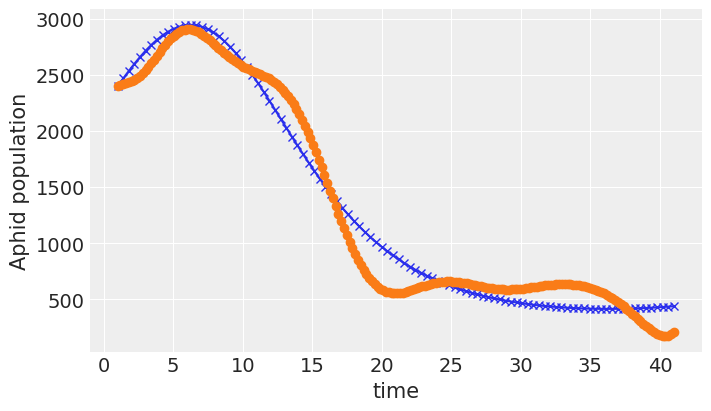

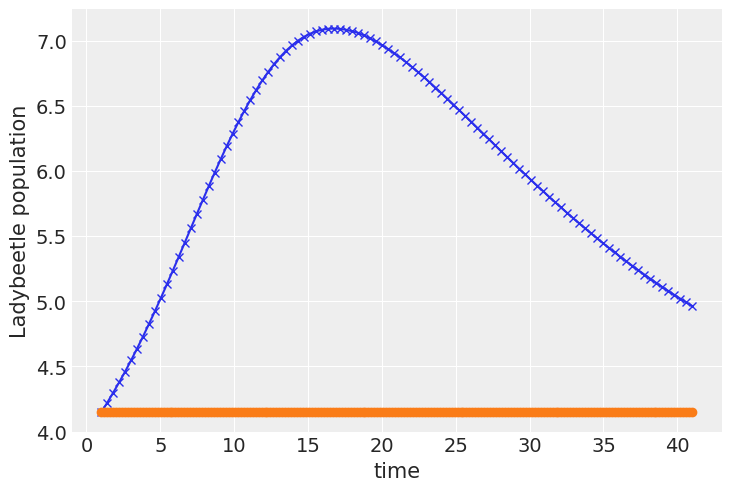

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_RMLM, u_RMLM, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_RMLM, v_RMLM, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [50]:
from SALib.sample.morris import sample as ee_sample
#from SALib.sample.saltelli import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [51]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = RMLM_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        RMLM_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 28/28 [00:00<00:00, 346.87it/s]


In [52]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


,$\mu^*$
$a1$,0.427967
$r1$,0.423333
$ef$,0.126728
$m$,0.021972
$a2$,1.08412e-11
$r2$,0


<ipython-input-53-120aa02beac8>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


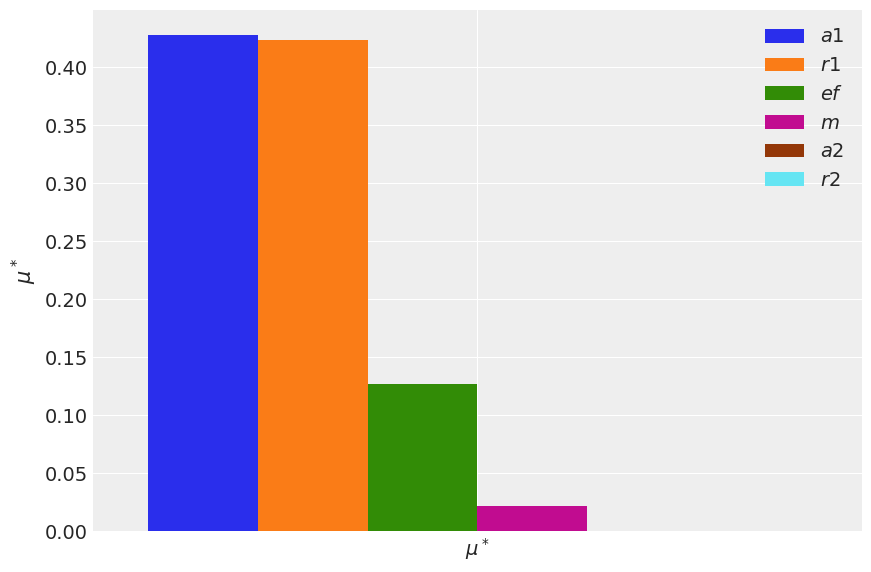

In [53]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_RMLM.png", dpi=300)
plt.show()

### Prey (pest) population

In [54]:
from SALib.sample.morris import sample as ee_sample
#from SALib.sample.saltelli import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [55]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_RMLM = RMLM_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_RMLM.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 28/28 [00:00<00:00, 429.45it/s]


In [56]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 268.23it/s]


,time_list,$r1$,$r2$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.493791,0,0.00549066,0.00217849,0.49854,2.47254e-14
1,1.808081,0.484194,0,0.0105825,0.0036326,0.501591,2.64361e-14
2,2.212121,0.474148,0,0.0166035,0.00499279,0.504256,3.18987e-14
3,2.616162,0.463479,0,0.0245203,0.00625649,0.505744,3.22482e-14
4,3.020202,0.452715,0,0.0343703,0.00735845,0.505556,3.43594e-14
...,...,...,...,...,...,...,...
94,39.383838,0.363195,0,0.167849,0.0660023,0.402953,3.21365e-11
95,39.787879,0.394479,0,0.161921,0.0662952,0.377305,3.78273e-11
96,40.191919,0.416687,0,0.155682,0.0759909,0.351641,4.00216e-11
97,40.595960,0.434644,0,0.150618,0.0856328,0.329106,4.57186e-11


In [57]:
df_sigmai

,time_list,$r1$,$r2$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.514083,0,0.0122674,0.00321103,0.470439,3.34848e-14
1,1.808081,0.498935,0,0.0195035,0.000764129,0.480798,2.74632e-14
2,2.212121,0.488823,0,0.0262489,0.00100371,0.483925,4.58622e-14
3,2.616162,0.475384,0,0.0373814,0.00112575,0.486109,5.44668e-14
4,3.020202,0.461888,0,0.0508352,0.00133151,0.485945,5.12621e-14
...,...,...,...,...,...,...,...
94,39.383838,0.437301,0,0.0562268,0.0988887,0.407584,4.98239e-11
95,39.787879,0.456372,0,0.060379,0.0940485,0.389201,5.98616e-11
96,40.191919,0.469373,0,0.0641268,0.0895323,0.376968,6.51953e-11
97,40.595960,0.477887,0,0.0673591,0.0855004,0.369253,7.24607e-11


<ipython-input-58-f2f38829a637>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


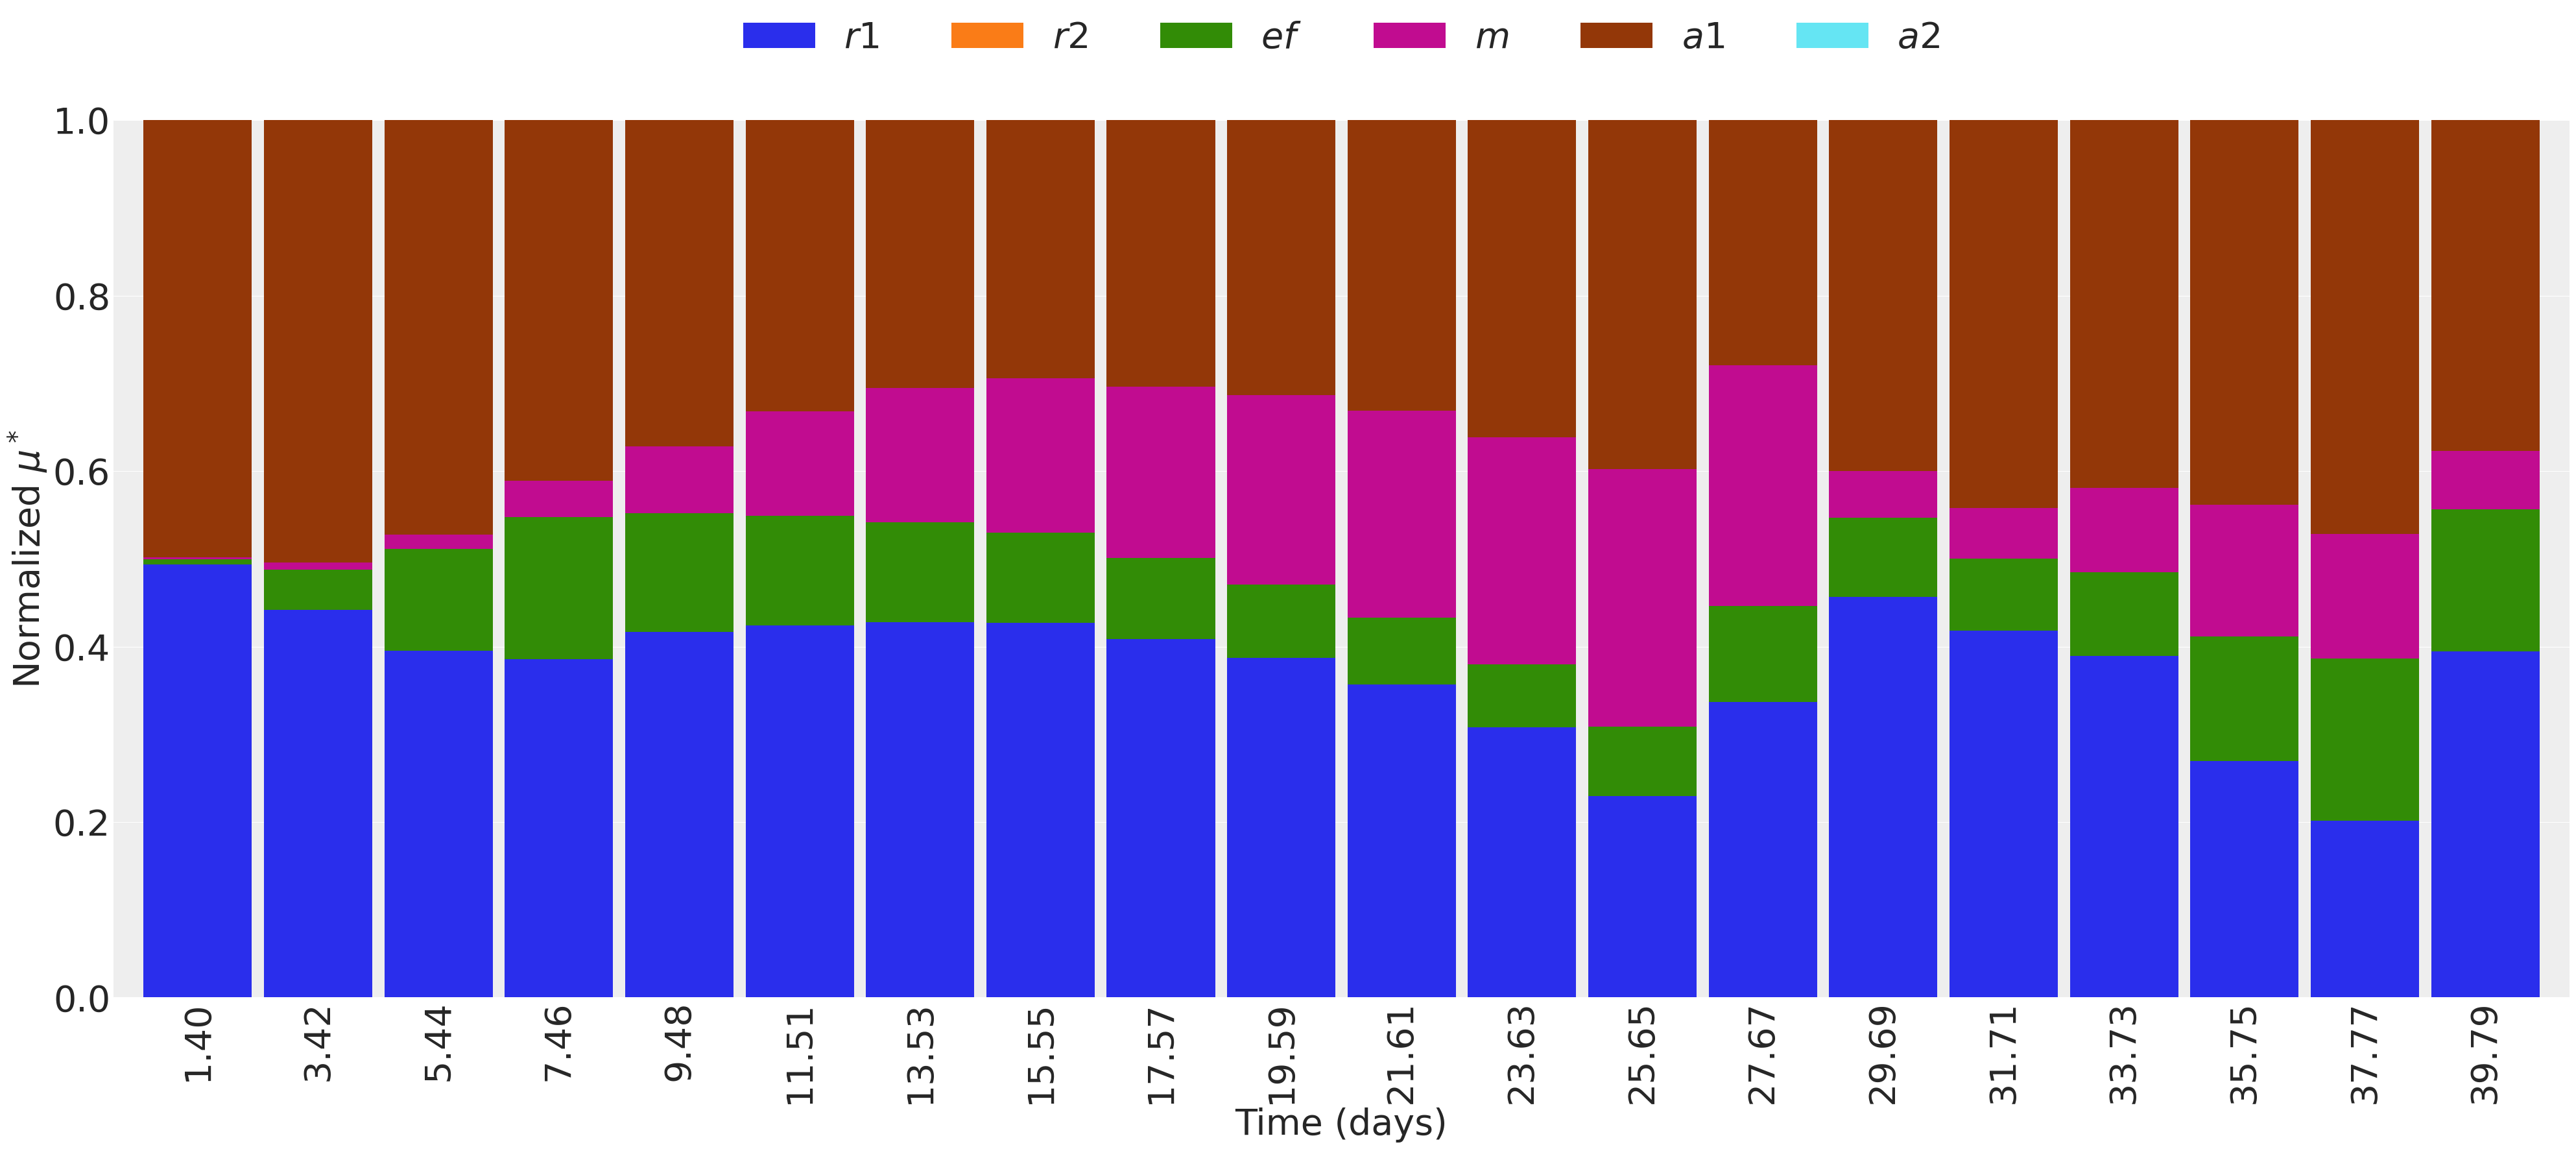

In [58]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_RMLM.png", dpi=300)
plt.show()

<ipython-input-59-0939011d523a>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


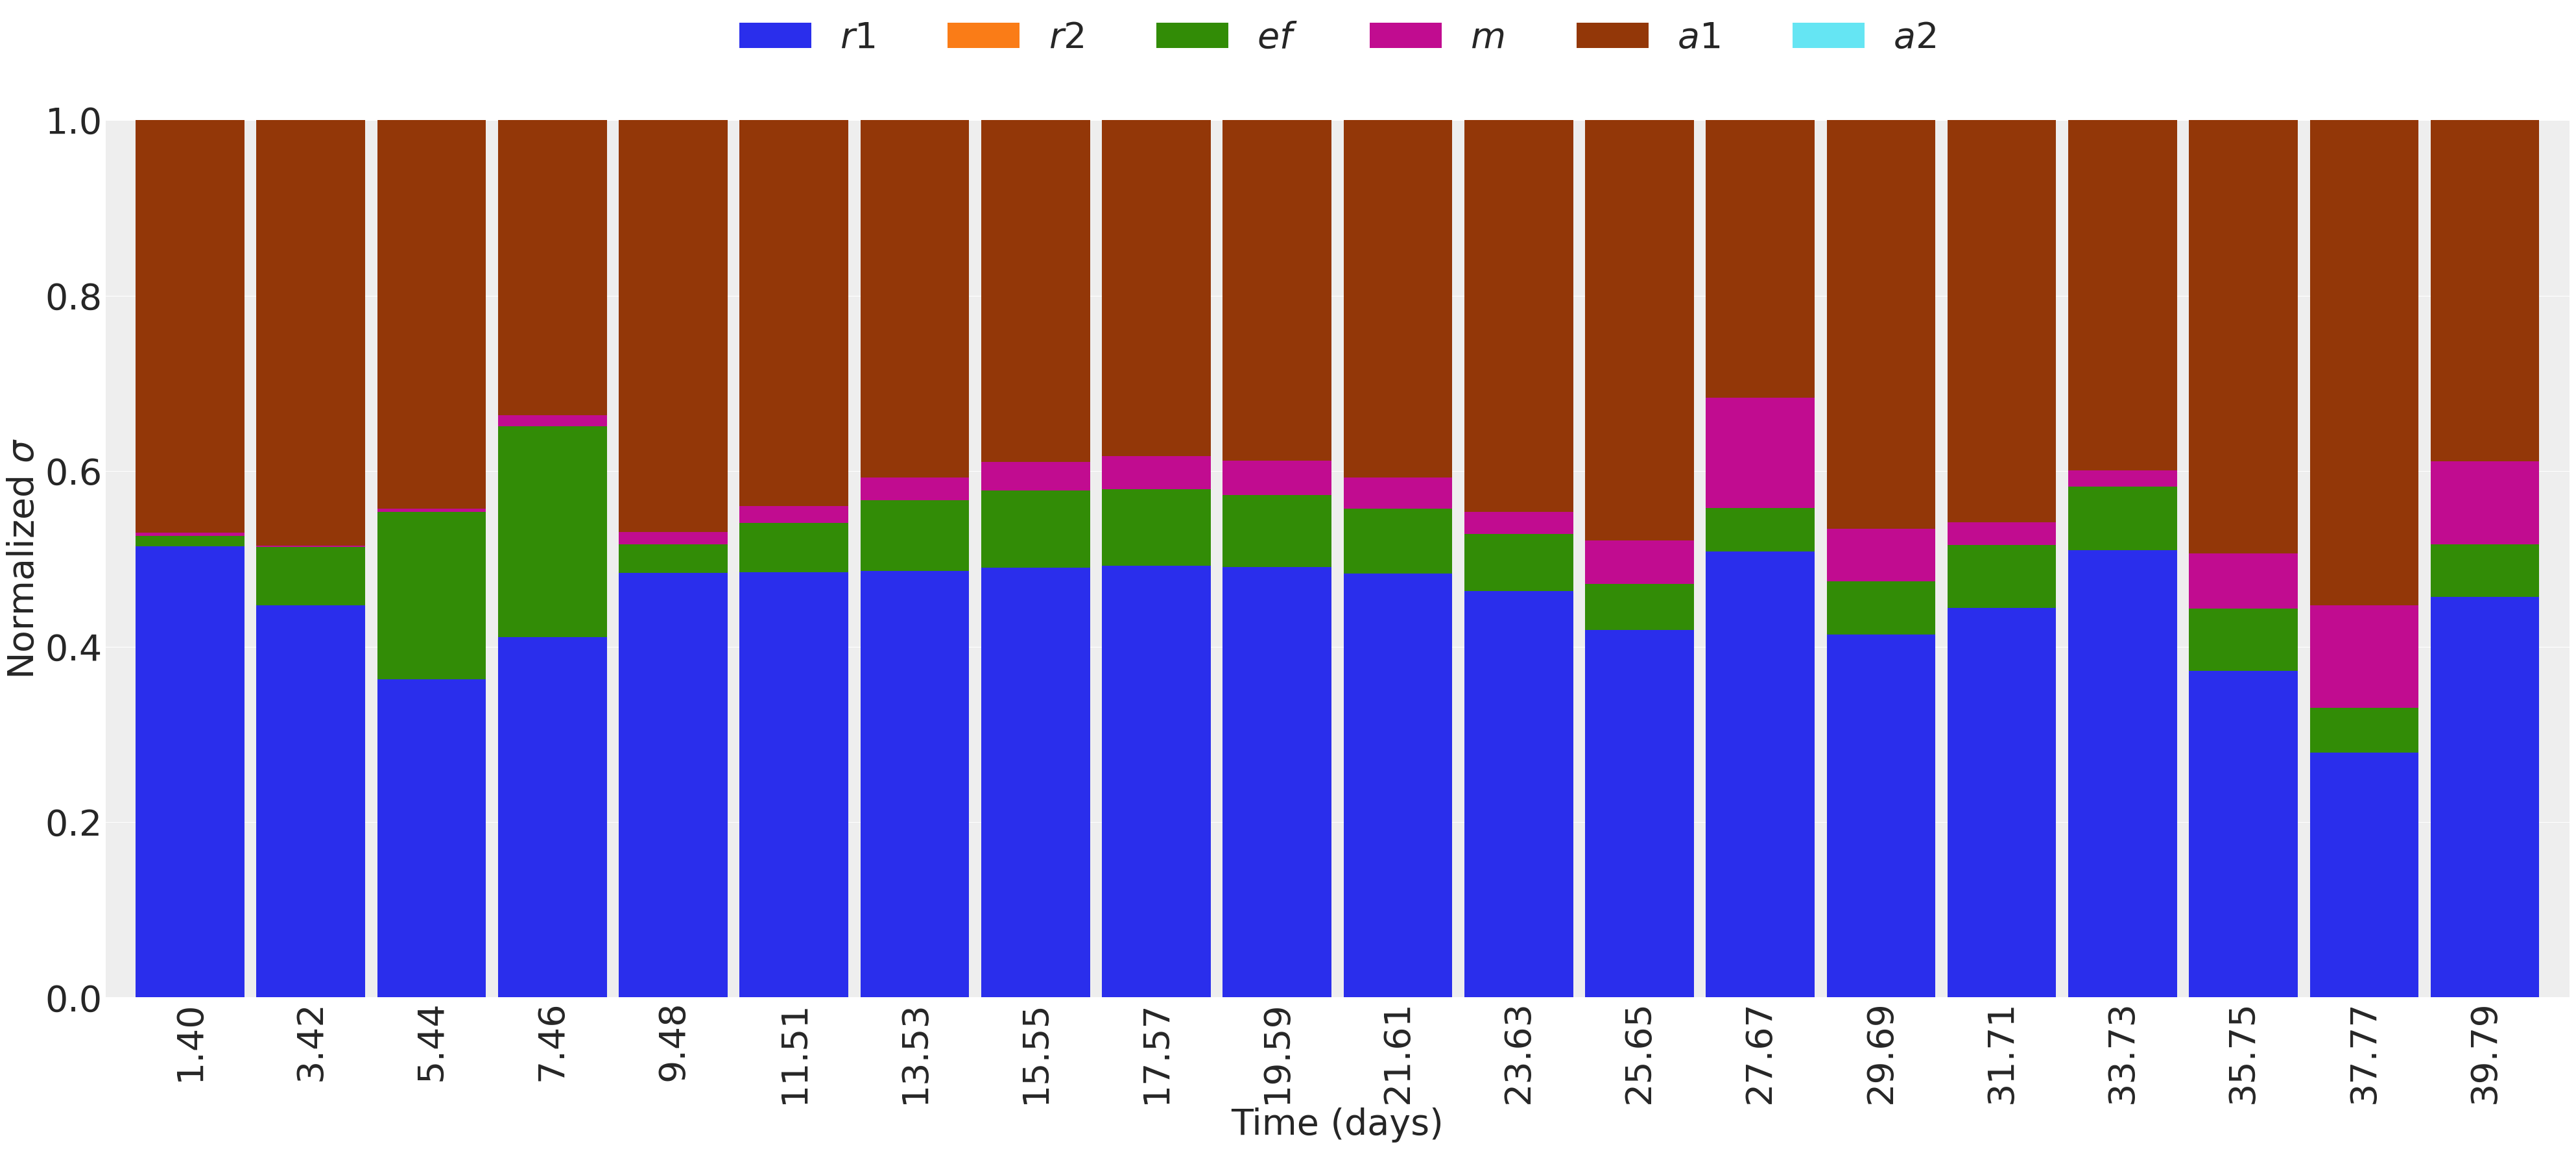

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_RMLM.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [60]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [61]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_RMLM,
    u_RMLM,
    v_RMLM,
    RMLM_model,
    mean_values_params
)

pest_time_list_derivative_array

/home/tungdil/.local/lib/python3.8/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'X' of function 'RMLM_model'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-45-99ed1c992ce5>", line 10:
@jit(nopython=True)
def RMLM_model(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([  186.57845257,    77.48451044,   -43.90461499,  -174.60407908,
        -317.3372384 ,  -471.83361565,  -637.12714048,  -812.4429107 ,
        -997.38784658, -1187.87801708, -1384.62554908, -1585.33829282,
       -1787.43198031, -1988.41314051, -2185.61764264, -2376.23855011,
       -2557.89774184, -2728.38131285, -2885.40012406, -3026.77833067,
       -3150.51809342, -3255.69428876, -3341.53413991, -3407.3030445 ,
       -3452.54946881, -3477.19772911, -3482.49623309, -3469.55725567,
       -3439.50223707, -3393.67080374, -3333.62907788, -3261.28634333,
       -3178.46427814, -3086.99424448, -2988.73134782, -2885.19832536,
       -2777.82003929, -2668.08119848, -2557.39851946, -2446.86052864,
       -2337.12175138, -2229.03814681, -2123.38526553, -2021.87250075,
       -1921.81297556, -1825.67240461, -1733.56309602, -1645.56483862,
       -1561.53655789, -1481.4246358 , -1405.24024411, -1332.97865665,
       -1264.61817067, -1199.96531577, -1138.8486026 , -1081.19625477,
      

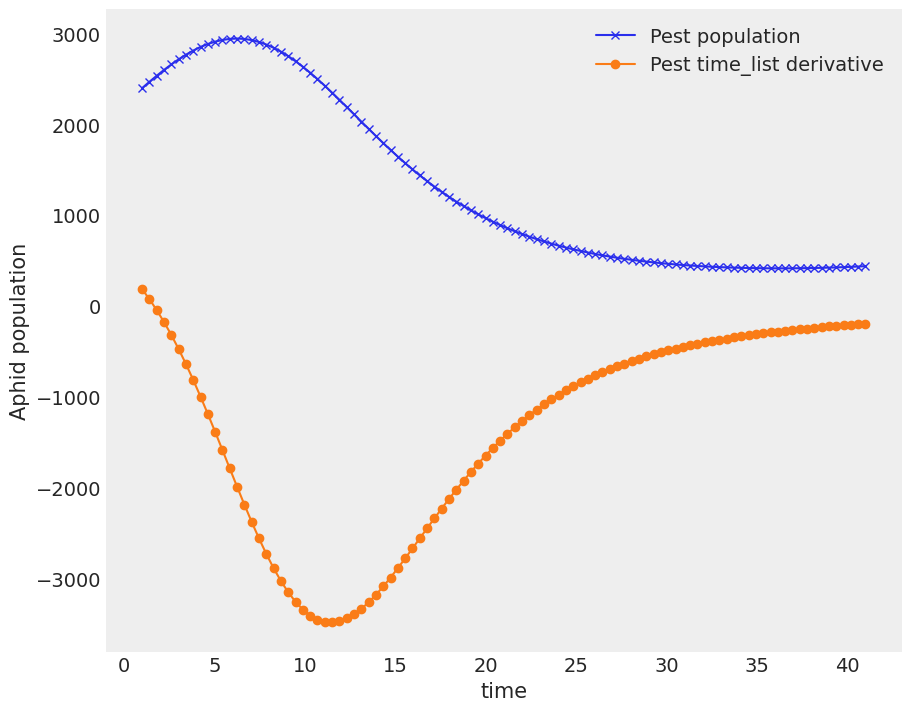

In [62]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_RMLM, u_RMLM, '-x', label='Pest population')
plt.plot(t_computed_RMLM, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_RMLM.png", dpi=300)
plt.show()

In [63]:
mean_values_params = [
    r1,
    r2,
    ef,
    m,
    a1,
    a2,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$ef$",
    r"$m$",
    r"$a1$",
    r"$a2$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)
#parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, seed=seed)

In [64]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_RMLM = RMLM_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_RMLM.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        RMLM_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

100%|██████████| 28/28 [00:00<00:00, 291.28it/s]


In [65]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 233.15it/s]


,time_list,$r1$,$r2$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.48629,0,0.00876397,0.00351677,0.501429,2.86936e-14
1,1.808081,0.46579,0,0.0205367,0.0063762,0.507297,3.36267e-14
2,2.212121,0.445431,0,0.0361207,0.0086935,0.509754,3.96837e-14
3,2.616162,0.423631,0,0.0578511,0.0106636,0.507855,4.6084e-14
4,3.020202,0.39892,0,0.0878993,0.0126371,0.500543,5.25649e-14
...,...,...,...,...,...,...,...
94,39.383838,0.274949,0,0.0655279,0.220589,0.438934,1.47029e-11
95,39.787879,0.253381,0,0.0635472,0.243943,0.439129,2.15139e-11
96,40.191919,0.251506,0,0.0596214,0.261852,0.42702,2.97683e-11
97,40.595960,0.265908,0,0.0542401,0.274295,0.405557,3.1511e-11


In [66]:
df_sigmai

,time_list,$r1$,$r2$,$ef$,$m$,$a1$,$a2$
0,1.404040,0.504343,0,0.0104476,0.000883253,0.484326,3.42691e-14
1,1.808081,0.489706,0,0.0239443,0.00111389,0.485236,4.71517e-14
2,2.212121,0.472148,0,0.0399967,0.00136095,0.486495,5.58622e-14
3,2.616162,0.449745,0,0.0618923,0.00159899,0.486763,6.45903e-14
4,3.020202,0.422336,0,0.0911253,0.00188273,0.484656,6.97703e-14
...,...,...,...,...,...,...,...
94,39.383838,0.361081,0,0.0835144,0.0356644,0.51974,1.98464e-11
95,39.787879,0.347888,0,0.0818822,0.0382222,0.532007,3.31869e-11
96,40.191919,0.341331,0,0.0794877,0.0394486,0.539733,4.70837e-11
97,40.595960,0.341243,0,0.0768061,0.0388143,0.543137,6.24903e-11


<ipython-input-67-8730967b3620>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


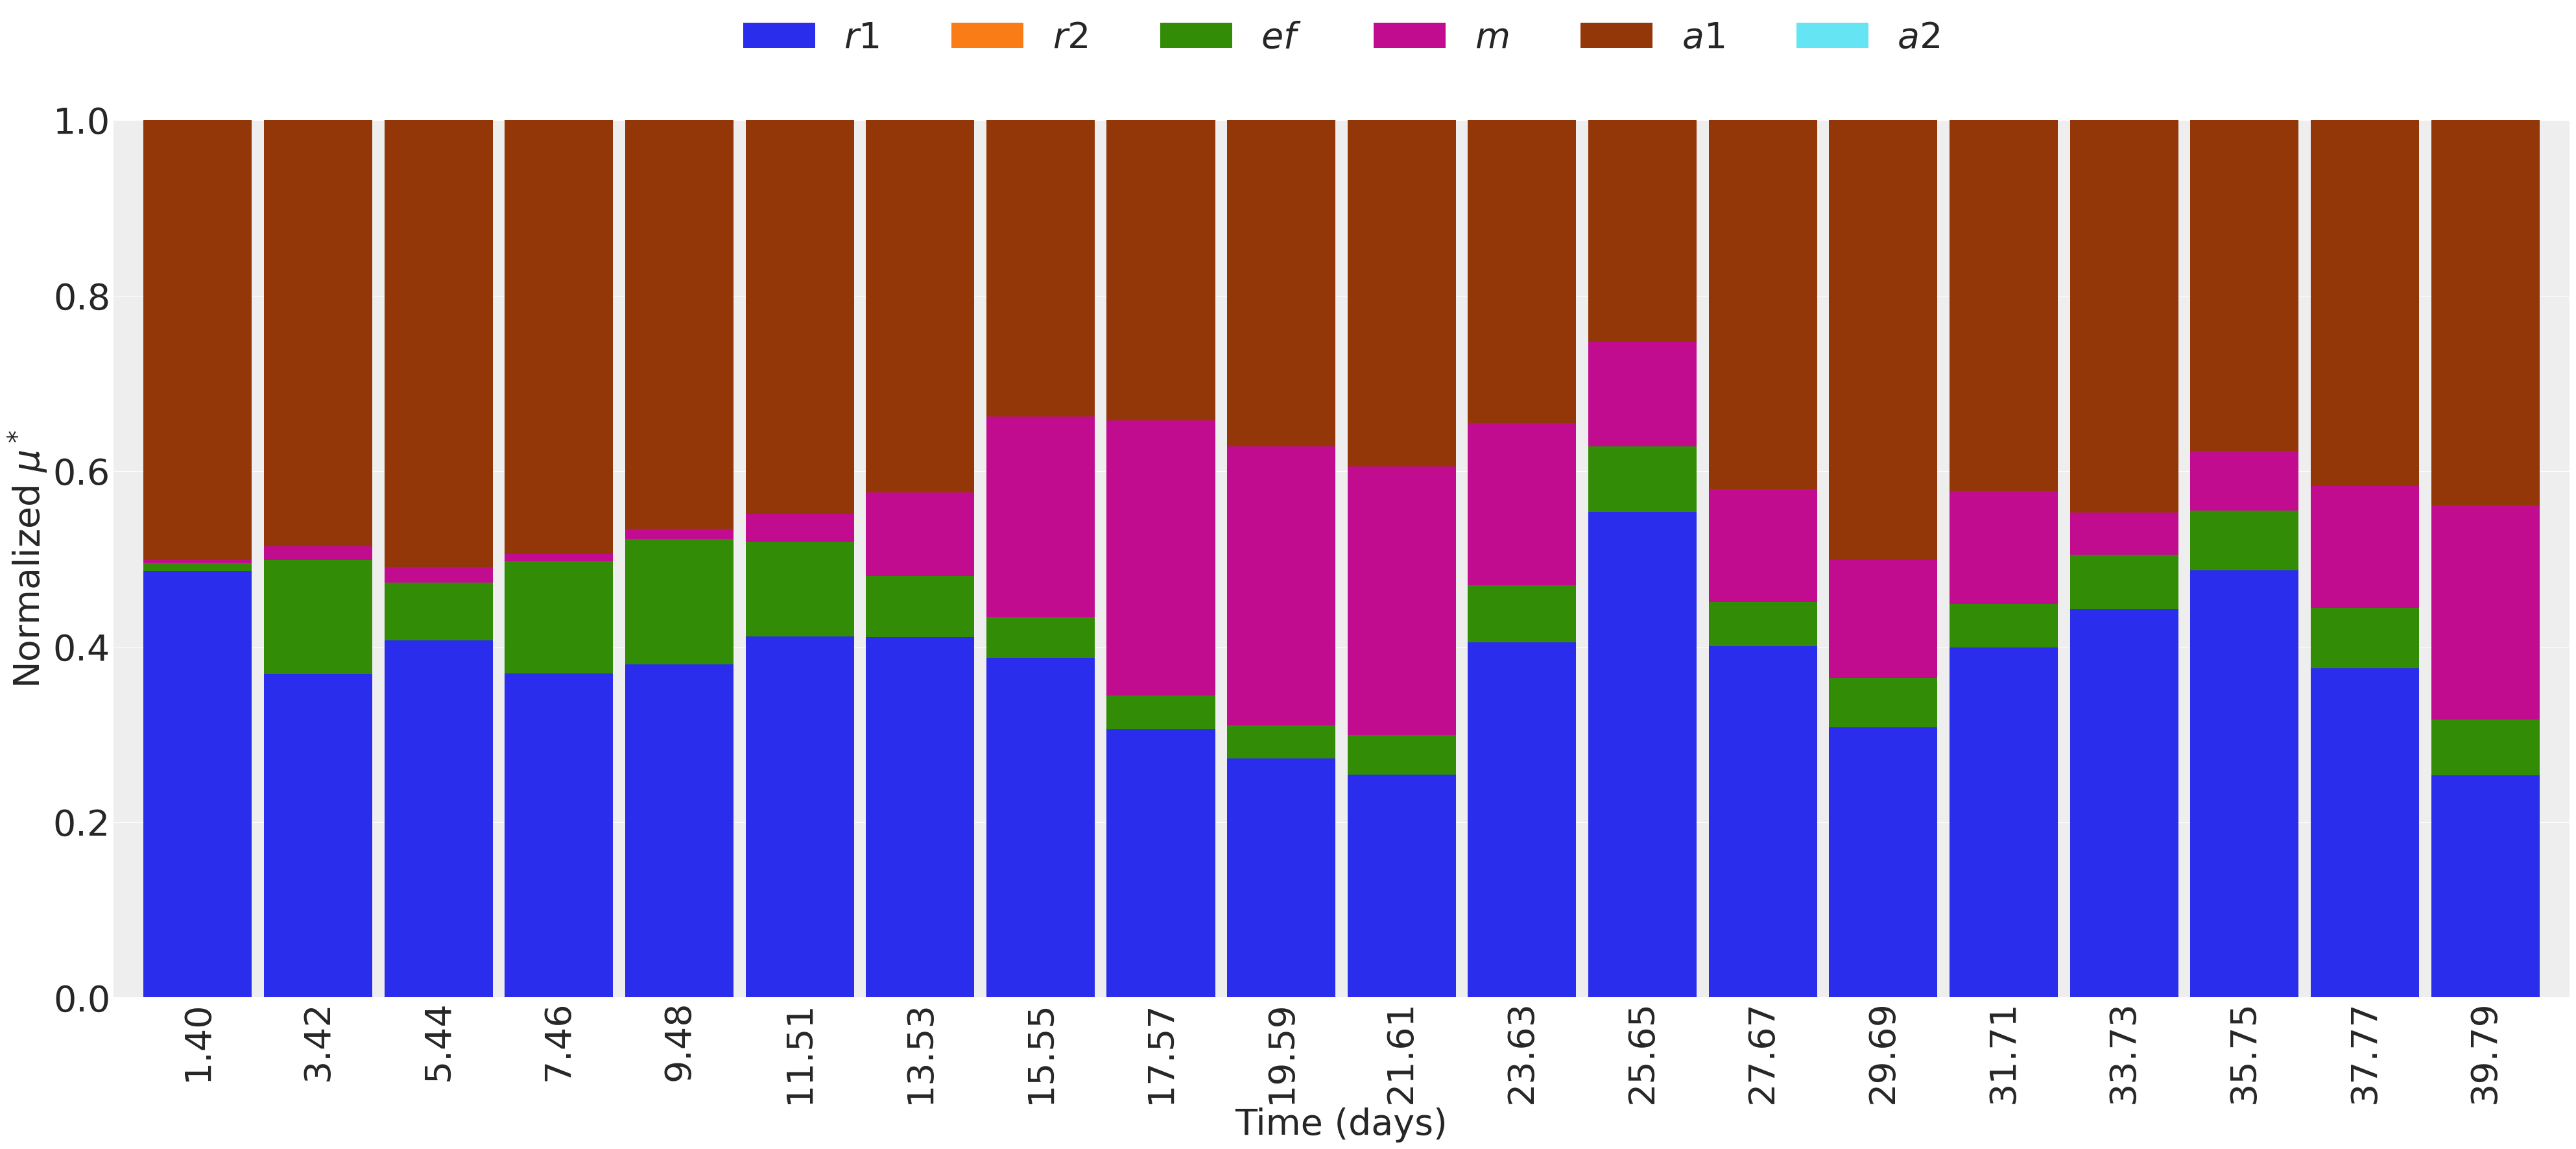

In [67]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_RMLM.png", dpi=300)
plt.show()

<ipython-input-68-3b894dc6c0f4>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


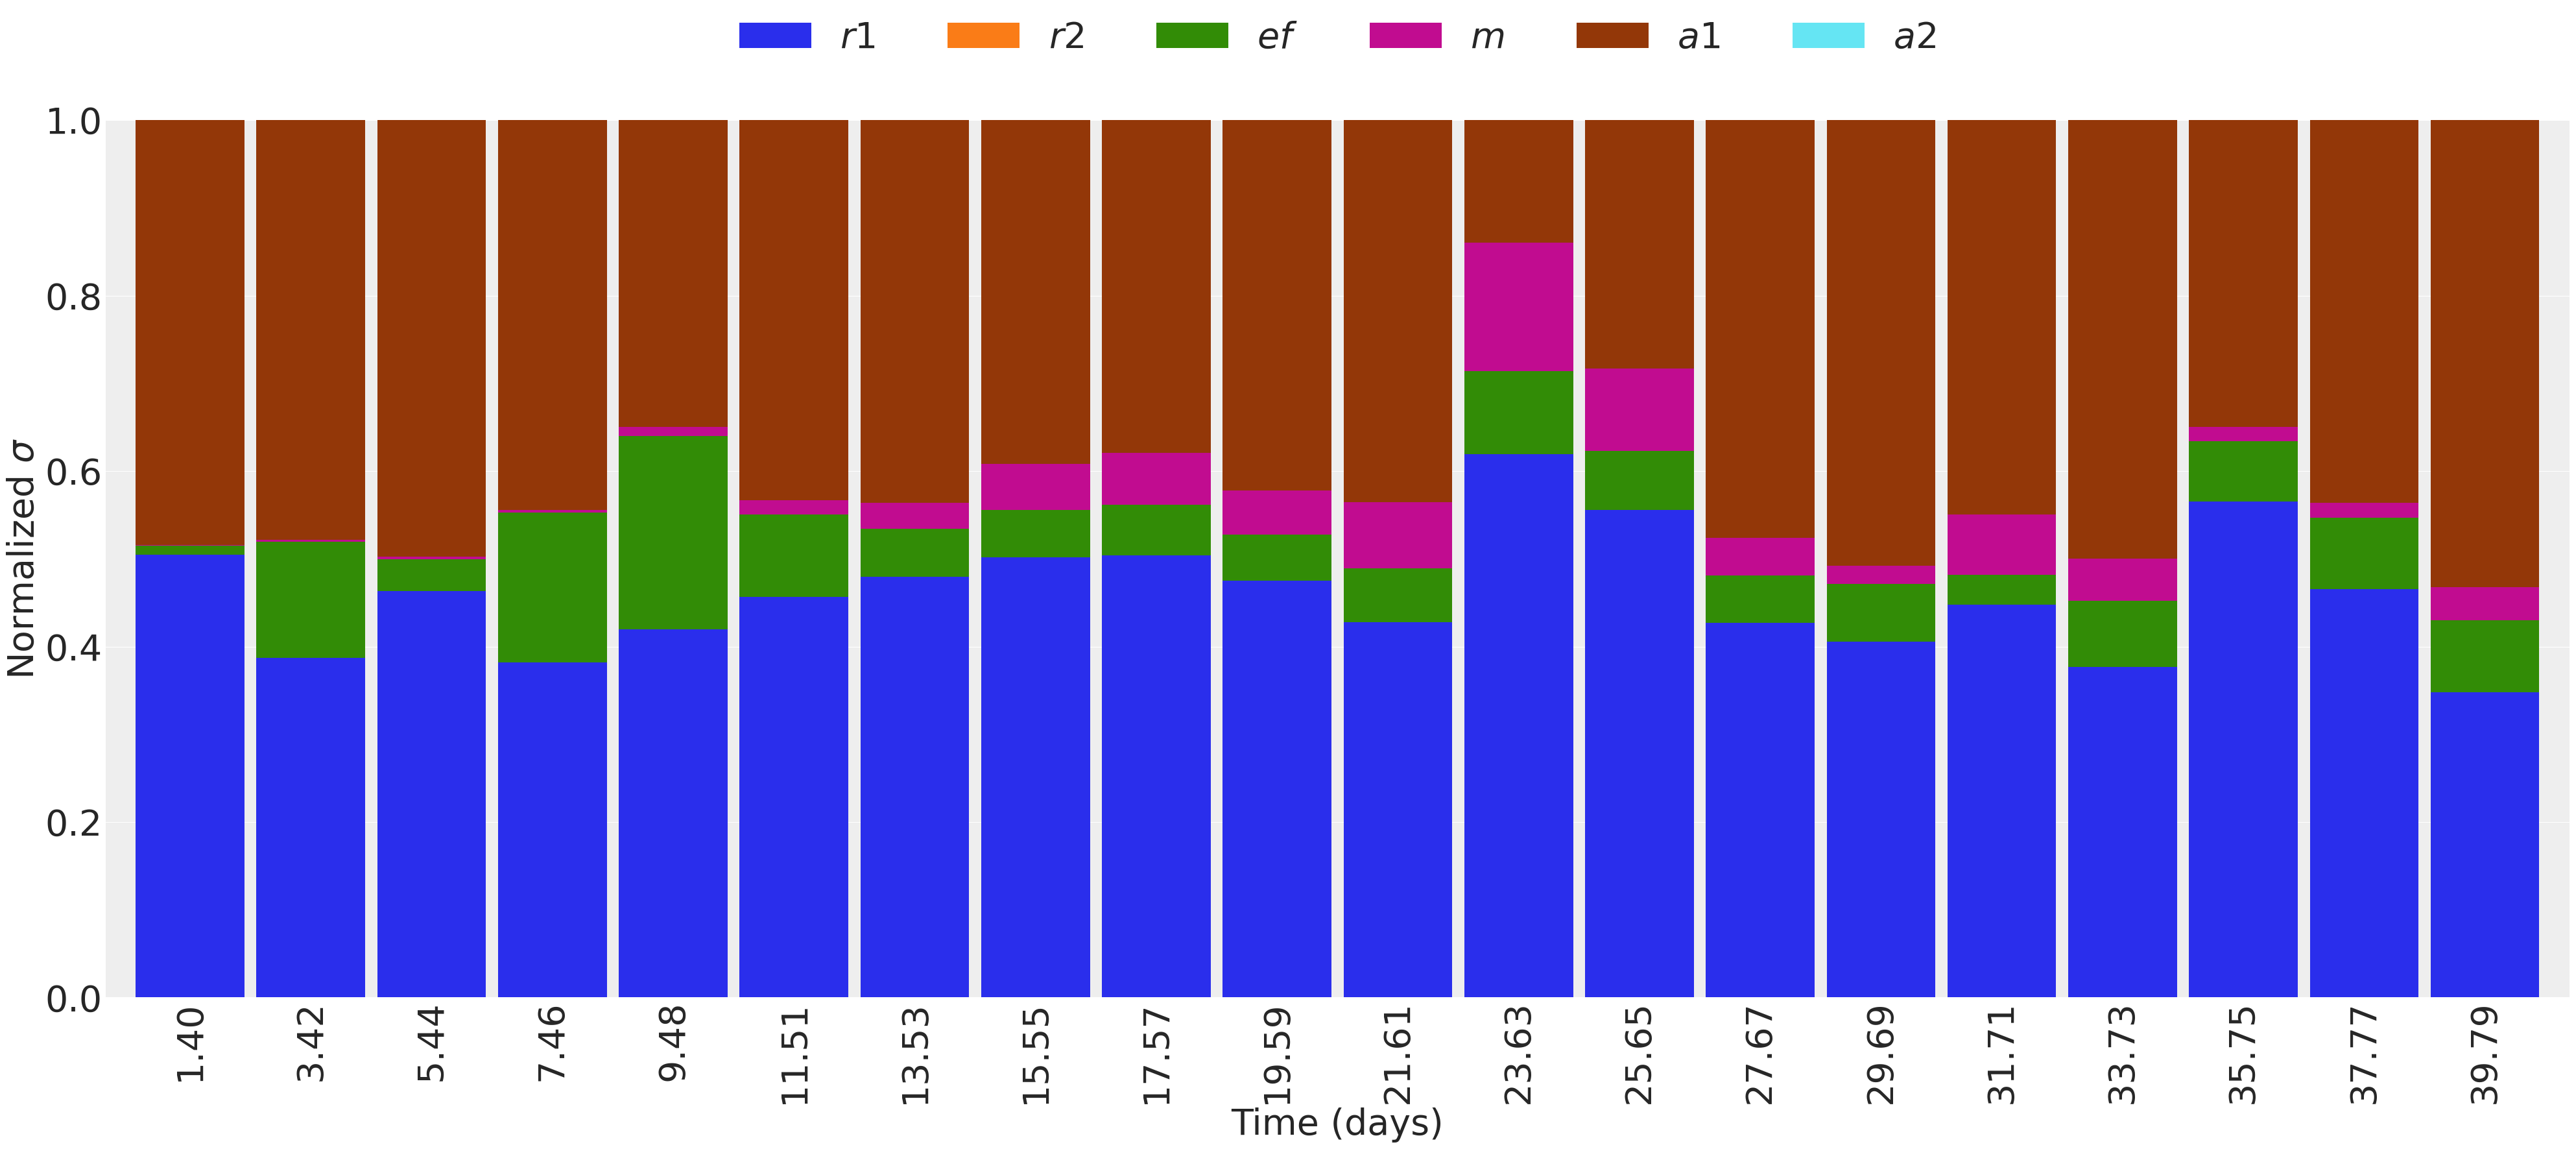

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_RMLM.png", dpi=300)
plt.show()

## Bayesian calibration

In [69]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # a1
        t.dscalar,  # a2
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def RMLM_ode_wrapper(time_list_exp, r1, r2, ef, m, a1, a2, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r1, r2, ef, m, a1, a2]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        RMLM_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [82]:
###### observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
#percent_calibration = 0.95
denom_min = 0.9
denom_max = 1.1

with pm.Model() as fine_model_RMLM:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=10.1,#( r1 * denom_min ),#9.3,#
        upper=10.4,#( 4 * r1 * denom_max ),#11,#
   )
    r2_ = pm.Data("r2", r2)
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=2.44,#( a1 * denom_min ),#2.25,#
        upper=2.6,#( 5.5 * a1 * denom_max ),#5,#
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "RMLM_model",
        RMLM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_ = pm.Uniform(
        "r1",
        lower=10.1,#( r1 * denom_min ),#9.3,#
        upper=10.4,#( 4 * r1 * denom_max ),#11,#
   )
    r2_ = pm.Data("r2", r2)
    ef_ = pm.Data("ef", ef)
    m_ = pm.Data("m", m)
    a1_ = pm.Uniform(
        "a1",
        lower=2.44,#( a1 * denom_min ),#2.25,#
        upper=2.6,#( 5.5 * a1 * denom_max ),#5,#
   )
    a2_ = pm.Data("a2", a2)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "RMLM_model",
        RMLM_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            ef_,
            m_,
            a1_,
            a2_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_RMLM:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_RMLM = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, a1, r1]


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
Sampling 6 chains for 2_000 tune and 6_0

-- Monte Carlo simulations done in 10.418 minutes


plt.hist(trace_calibration_RMLM['r1'], bins=35)
plt.show()

In [83]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a1",
]

  0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/pytho

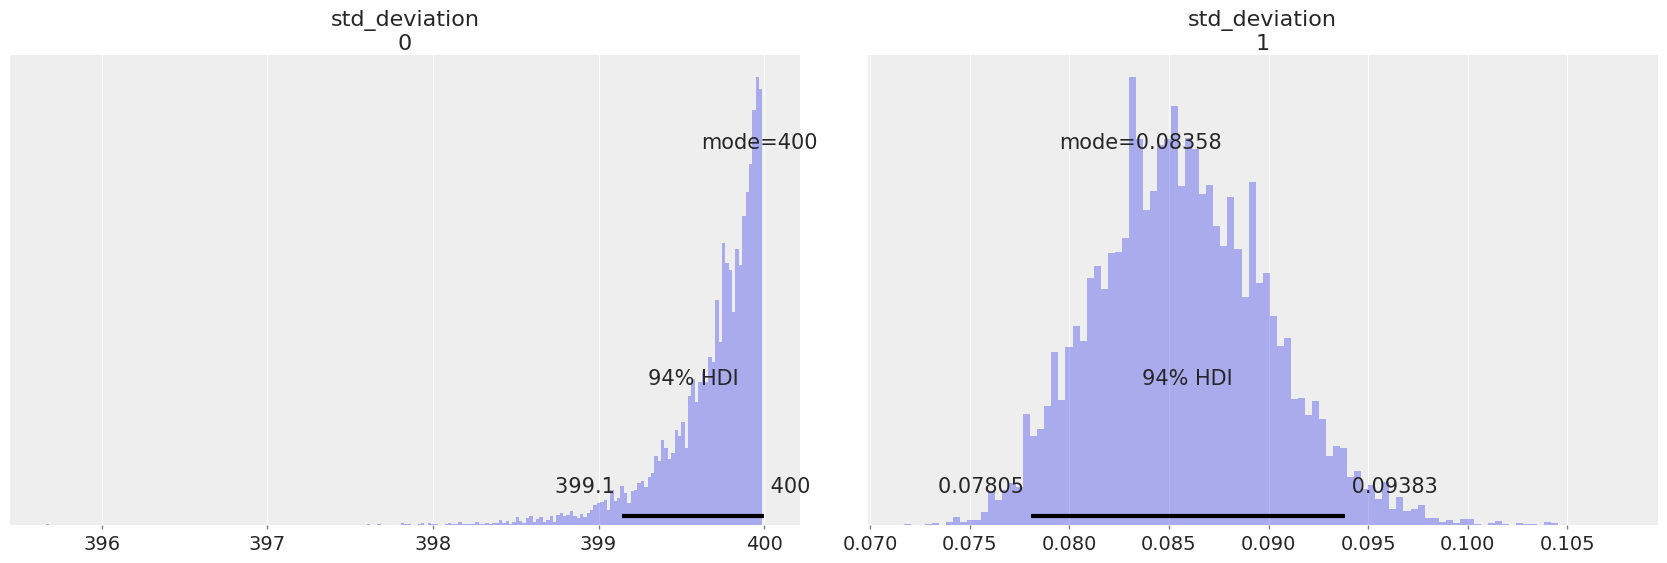

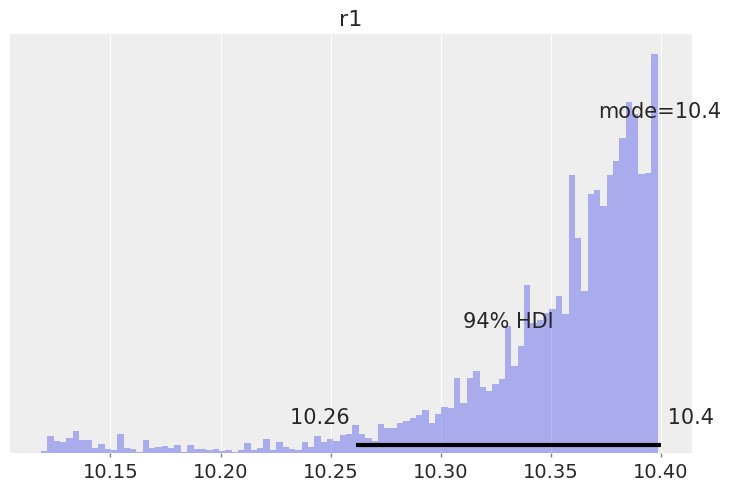

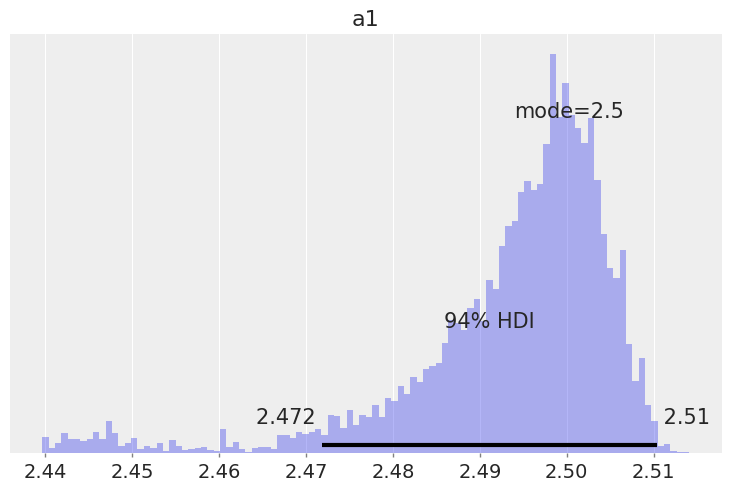

In [84]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_RMLM[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_RMLM.png")

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/densit

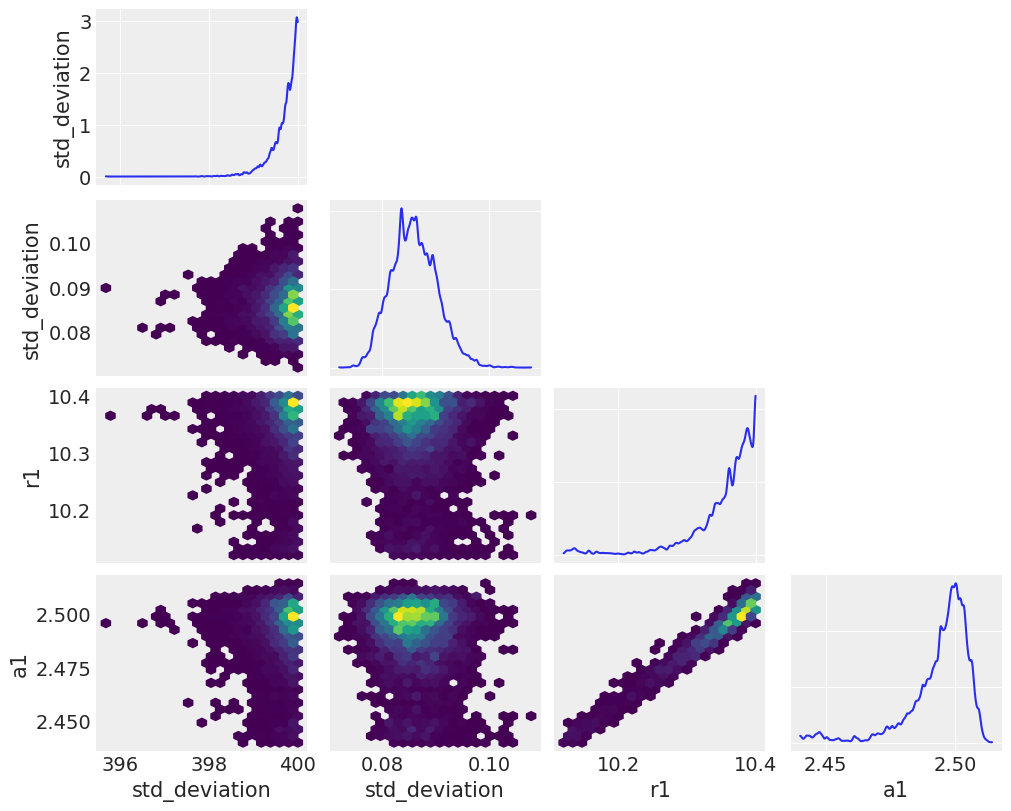

In [85]:
az.plot_pair(
    trace_calibration_RMLM,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_RMLM.png")

In [86]:
df_stats_summary = az.summary(
    data=trace_calibration_RMLM,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
std_deviation[0],399.692113,0.306857,399.141760,399.999898
std_deviation[1],0.085902,0.004312,0.078051,0.093831
r1,10.351340,0.051749,10.261767,10.400000
a1,2.493959,0.012491,2.471885,2.510381


Auxiliary functions to compute the Most Probable Value (MPV):

In [87]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [88]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_RMLM, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_RMLM.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for std_deviation:   0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in exp
  result += self.weights[i]*exp(-energy)
/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in multiply
  result += self.weights[i]*exp(-energy)
Calculating MPV from KDE for a1: 100%|██████████| 3/3 [00:39<00:00, 13.22s/it]           


,mean,sd,hdi_3%,hdi_97%,mpv
std_deviation[0],399.692113,0.306857,399.141760,399.999898,399.940195
std_deviation[1],0.085902,0.004312,0.078051,0.093831,0.085702
r1,10.351340,0.051749,10.261767,10.400000,10.386367
a1,2.493959,0.012491,2.471885,2.510381,2.499989


In [89]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_RMLM["RMLM_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_RMLM["RMLM_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_RMLM["RMLM_model"], 50, axis=0)

<ipython-input-90-a0afb57bd46f>:46: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


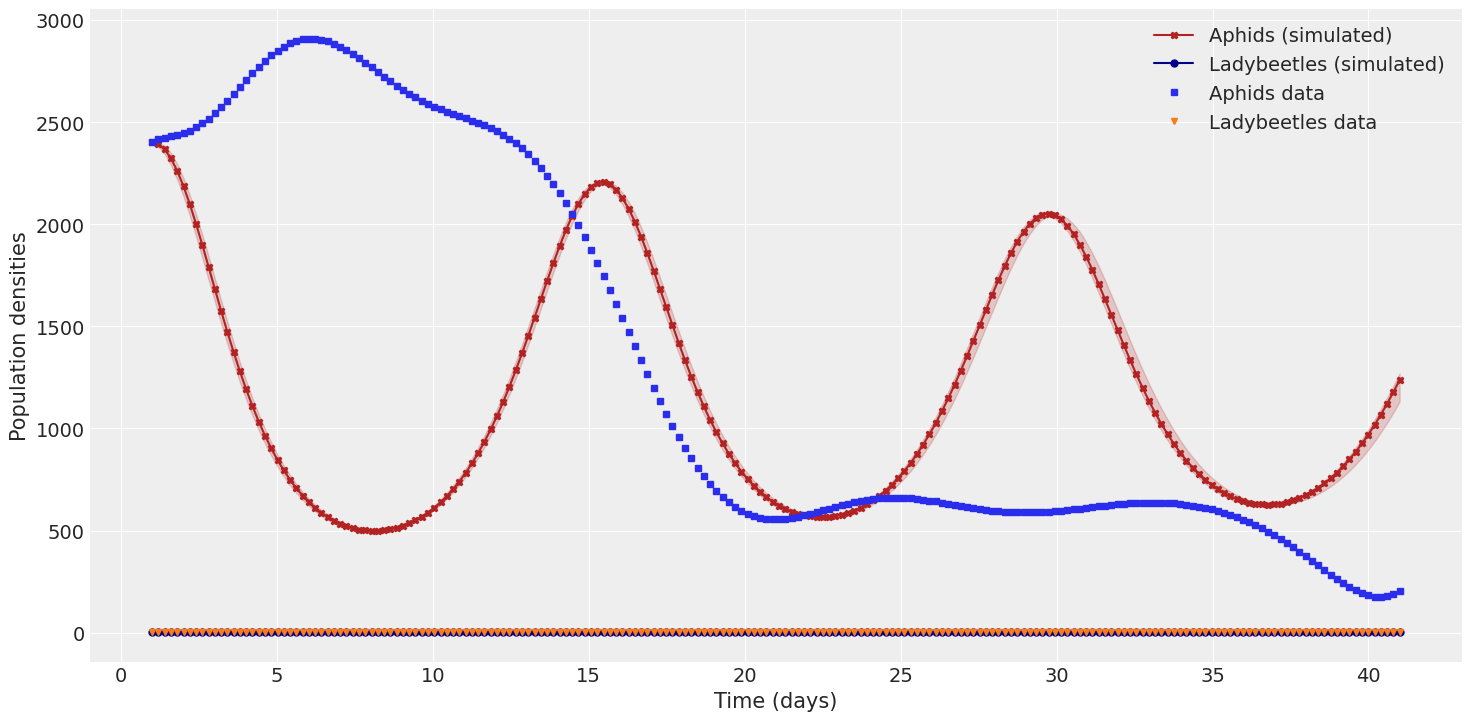

In [90]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_RMLM.png", dpi=300)
plt.show()

<ipython-input-91-c304d3978c24>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


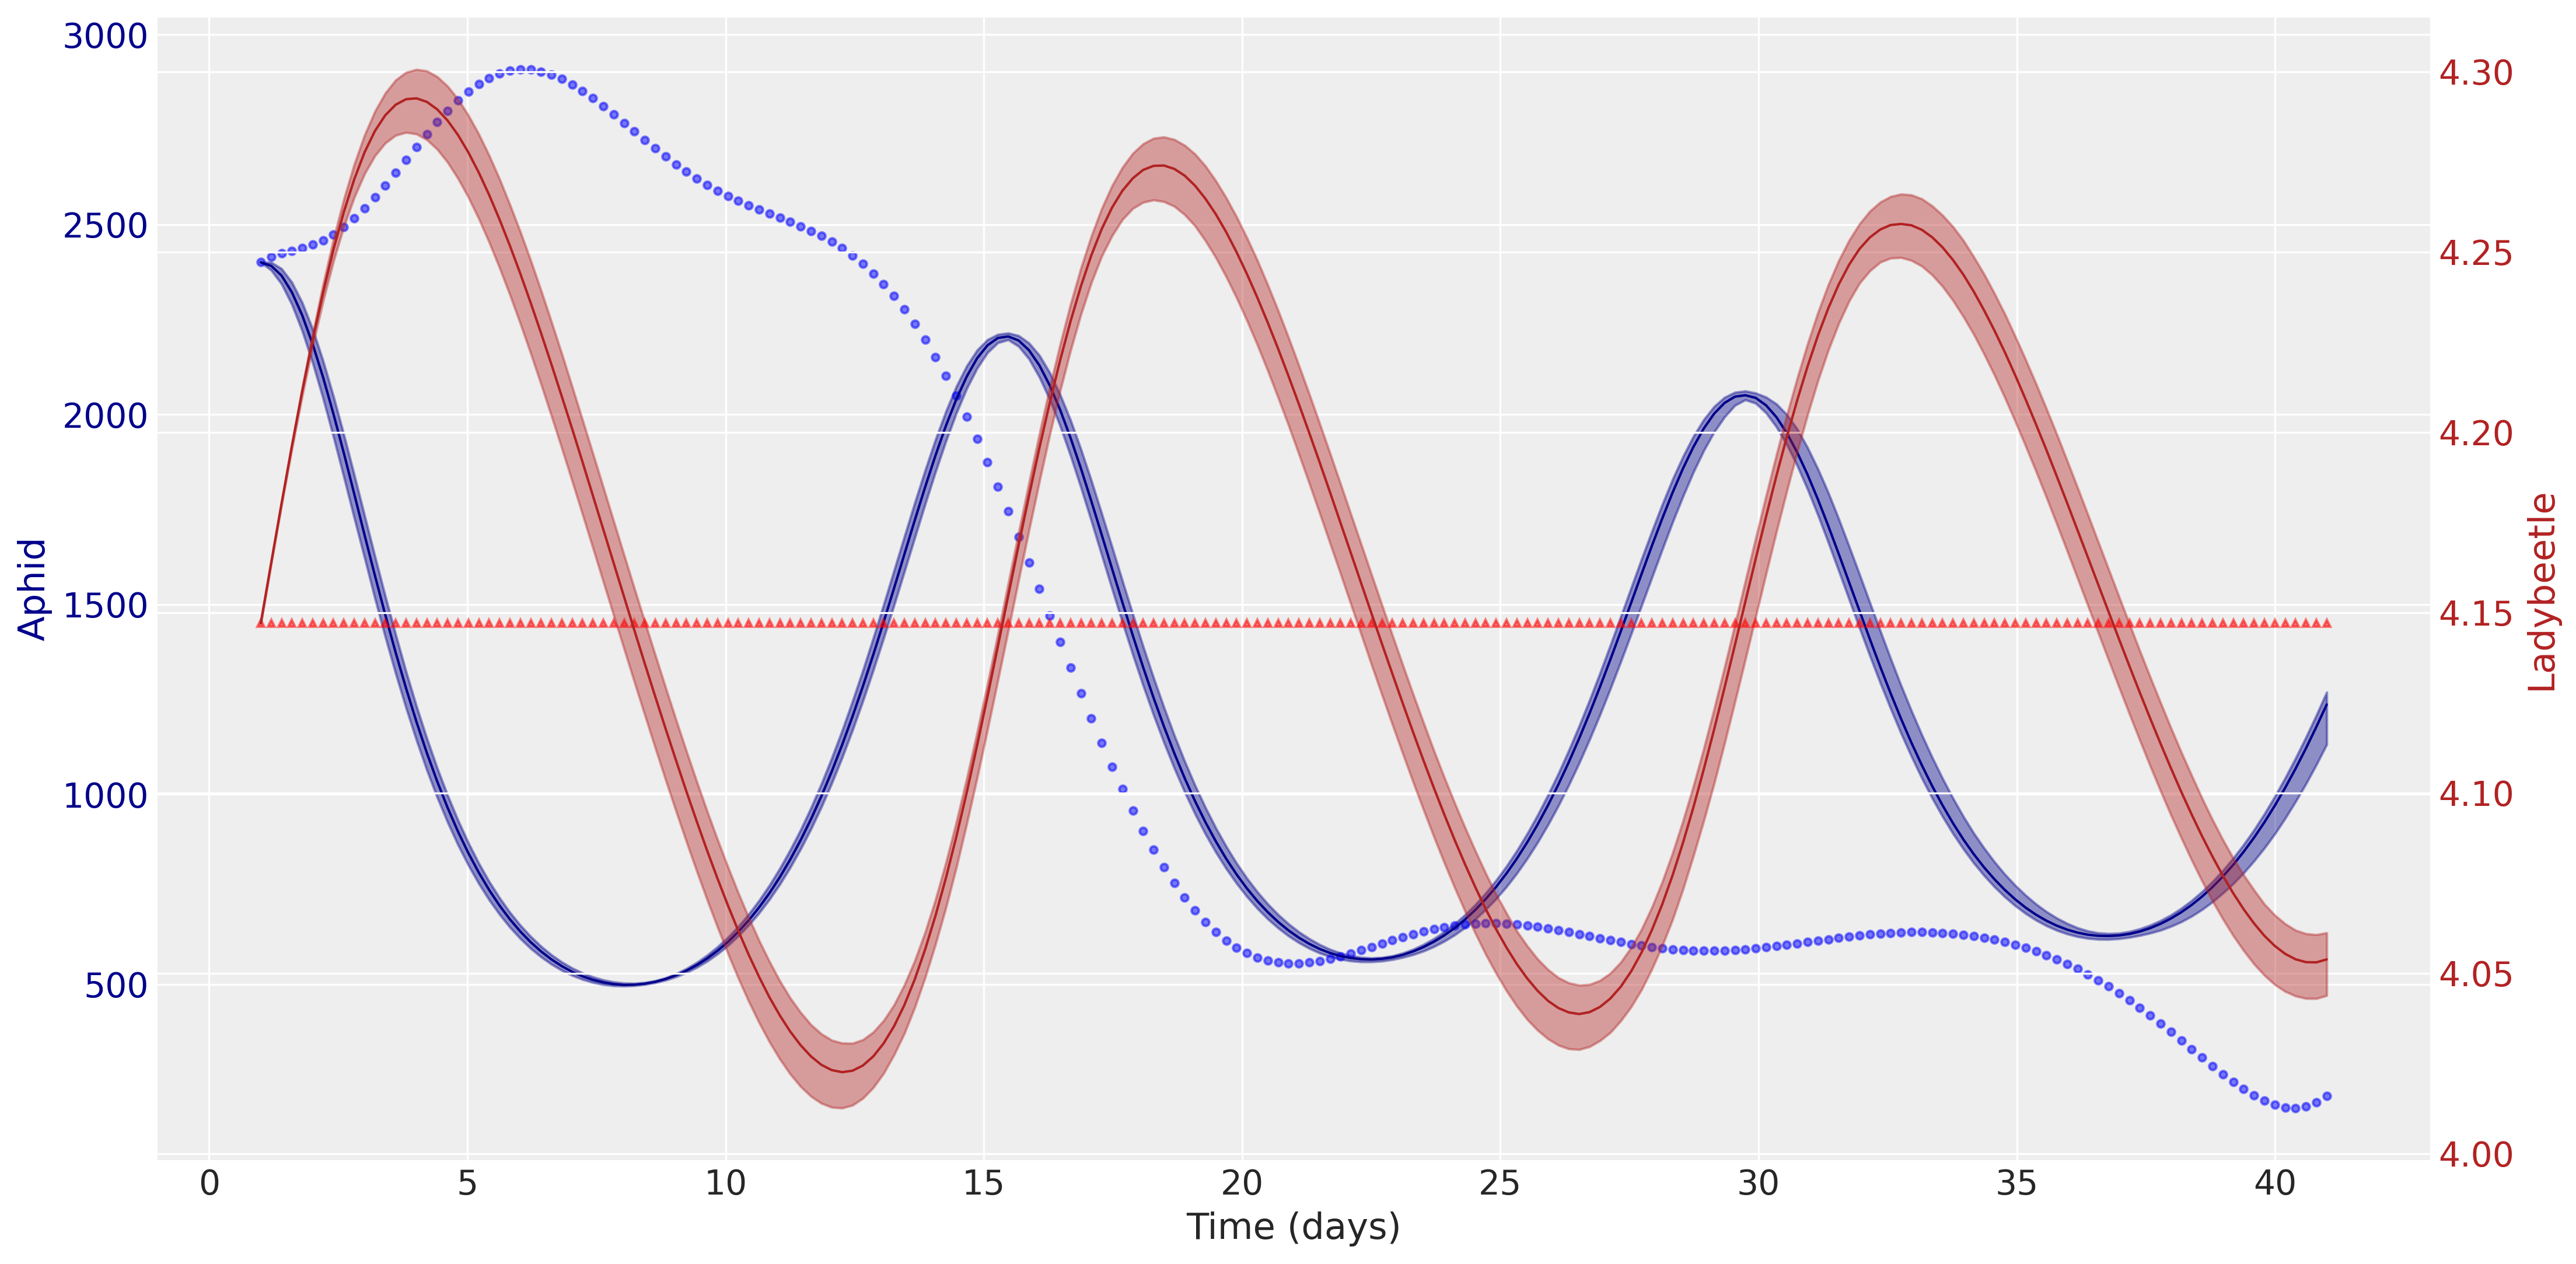

In [91]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

plt.tight_layout()
plt.savefig("img/calibration_RMLM.png", dpi=300)
plt.show()

In [92]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_RMLM.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_RMLM.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a1 realizations: 100%|██████████| 2/2 [00:00<00:00, 2033.11it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.080 seconds


In [93]:
df_realizations

,r1,a1
0,10.124579,2.442744
1,10.122791,2.442309
2,10.122791,2.442309
3,10.122791,2.442309
4,10.122791,2.442309
...,...,...
35995,10.319855,2.486354
35996,10.319855,2.486354
35997,10.319855,2.486354
35998,10.286043,2.481453
